# 🚀 CareerGraph AI — Multi-Agent System using LangGraph & LangChain

**CareerGraph AI** is an intelligent, LLM-powered multi-agent framework designed to deliver personalized career guidance.  
It integrates multiple specialized agents (e.g., `resume_builder`, `interview_coach`, `skill_analyzer`, etc.) within a LangGraph-based orchestration pipeline.

### 🔍 Key Features
- **Multi-Agent Workflow:** Dynamically routes user queries to specialized agents via a central `router`.
- **Context-Aware Conversation:** Maintains conversational memory with summarization for long-term context.
- **Dynamic Exit Management:** Gracefully handles user exits using a conversation-aware `exit_chain`.
- **Agent Specialization:**
  - 🧭 `learning_path_advisor` — Personalized learning recommendations  
  - 🧠 `skill_analyzer` — Analyzes and improves skill portfolios  
  - 💼 `resume_builder` — Generates ATS-friendly resumes  
  - 🎯 `interview_coach` — Provides tailored interview preparation  
  - 🎓 `course_recommender` & `project_recommender` — Suggests career-enhancing projects and courses  
- **Graph-Based Architecture:** Built using `LangGraph` with conditional routing and sequential agent execution.

### ⚙️ Components Overview
1. **StateGraph Setup:** Defines all nodes and transitions between agents.  
2. **Agent Nodes:** Each agent operates as a modular function processing the shared `state`.  
3. **Conversation Loop:** Interactive CLI loop that handles user input, memory, and routing.  

---

> 💡 *This notebook serves as a complete, self-contained prototype of the CareerGraph AI system — combining LangGraph, LangChain, and LLM reasoning to simulate an adaptive career assistant.*


### `get_user_profile_from()` — Dummy Profile Generator

This function creates a **realistic, structured test user profile** for CareerGraph AI.

---

#### Purpose
Used for:
- Development and testing when LinkedIn or live profile fetching isn’t active.
- Ensuring downstream agents (like `resume_builder`, `interview_coach`, etc.) can process valid structured input.

---

#### Data Included

| Section | Description |
|----------|-------------|
| **Skills** | A wide range of AI, ML, and software development skills. |
| **Certifications** | Popular industry credentials (Google, IBM, DeepLearning.AI, etc.). |
| **Projects** | Realistic AI + web projects with GitHub links. |
| **Education** | Undergraduate degree with CGPA and timeline. |
| **Experience** | Empty template (acts as placeholder). |

In [19]:
def get_user_profile_from():
    """
    Returns a structured dummy user profile for internal testing.

    Returns:
        dict: A dictionary containing user data with the following keys:
              - 'education'
              - 'certifications'
              - 'projects'
              - 'skills'
              - 'experience'
    """

    # Skills
    skills = [
        'Agentic AI', 'Retrieval Augmented Generation (RAG)', 'Large Language Models (LLMs)',
        'LangChain', 'Django', 'LSTM', 'Flask', 'Transformers', 'RNN', 'TensorFlow',
        'Supervised Learning', 'Unsupervised Learning', 'Pytorch', 'CNN', 'DBMS', 'DSA',
        'Statistics', 'SQL', 'AI', 'Linear Algebra', 'Calculus', 'PCA', 'Python',
        'Seaborn', 'Pandas', 'Numpy', 'Matplotlib', 'Scikit-learn', 'Data Analytics',
        'Data Science', 'Machine Learning', 'Jupyter Notebook', 'Git'
    ]

    # Certifications
    certifications = [
        {'name': 'Google Advanced Data Analytics', 'organization': 'Google'},
        {'name': 'IBM Data Science Professional Certificate', 'organization': 'IBM'},
        {'name': 'IBM RAG and Agentic AI: Build Next-Gen AI Systems', 'organization': 'IBM'},
        {'name': 'Deep Learning', 'organization': 'DeepLearningAI'},
        {'name': 'Machine Learning', 'organization': 'DeepLearningAI'},
        {'name': 'Mathematics for Machine Learning Specialization', 'organization': 'Imperial College London'},
        {'name': 'Mathematics for Machine Learning and Data Science', 'organization': 'DeepLearning.AI'},
        {'name': 'Python for Everybody Specialization', 'organization': 'University of Michigan'}
    ]

    # Projects
    projects = [
        {
            'name': 'BiasBusterAI: Text Bias Detection System',
            'start_date': 'October 2025',
            'end_date': 'October 2025',
            'description': (
                'Developed AI web app detecting biases (race, gender, profession, religion) '
                'with Bidirectional LSTM + Self Attention, achieving ~98% accuracy via TensorFlow. '
                'Created Flask interface with Plotly for real-time visualization of bias probabilities '
                'and attention weights. https://github.com/sheb1lmsp/BiasBusterAI'
            )
        },
        {
            'name': 'SmartAttend: An Automated Attendance Management System',
            'start_date': 'May 2025',
            'end_date': 'August 2025',
            'description': (
                'Developed a smart attendance management system using facial recognition to automate '
                'classroom attendance tracking. Leveraged PyTorch, MTCNN, and InceptionResNetV1 for '
                'face detection and recognition. Integrated with a Django web application featuring '
                'role-based dashboards. Streamlined attendance via group photo analysis. '
                'https://github.com/sheb1lmsp/smart_attend'
            )
        }
    ]

    # Education
    education = [
        {
            'degree': 'Bachelor of Computer Applications',
            'university': 'Bangalore University',
            'start_date': 'August 2022',
            'end_date': 'June 2025',
            'cgpa': '8.82'
        }
    ]

    # Experience (Empty Placeholder)
    experience = [
        {
            'title': '',
            'employment_type': '',
            'company': '',
            'start_date': '',
            'end_date': '',
            'location': '',
            'description': ''
        }
    ]

    # Return Unified Profile
    return {
        'education': education,
        'certifications': certifications,
        'projects': projects,
        'skills': skills,
        'experience': experience
    }


### Initialize LLM (Google Gemini)

This cell initializes the **Google Gemini 2.5 Flash** model using LangChain’s `ChatGoogleGenerativeAI` interface.

Steps performed:
1. Loads environment variables from the `.env` file (e.g., `GOOGLE_API_KEY`).
2. Creates an instance of the Gemini model, which will serve as the main **language reasoning engine** for the CareerGraph AI system.

This model will be responsible for all text understanding, response generation, and multi-agent coordination tasks within the project.


In [20]:
# Import required modules
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI

# Load environment variables (e.g., GOOGLE_API_KEY) from .env file
load_dotenv()

# Initialize the Google Gemini 2.5 Flash model
# This model will handle reasoning, conversation, and decision-making tasks
llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

### Define Data Structures for User Profile and Agent State

This cell defines the **typed data schemas** used throughout the CareerGraph AI system.  
It uses Python’s `TypedDict` to strictly type-check dictionaries for different user-related entities and the global agent state.

**Defined Classes:**
- **Project** – Represents user project details.
- **Certification** – Stores certification data.
- **Education** – Contains academic information.
- **Experience** – Captures professional experience details.
- **State** – Central structure that holds user input, selected agent action, contextual memory, and AI responses.

These schemas ensure consistency and reliability when passing structured data between different AI agents and components.
    

In [21]:
# Import typing utilities for structured data representation
from typing import TypedDict, Literal, List, Dict, Optional, Any

# Define a schema for user projects
class Project(TypedDict):
    name: str
    start_date: str
    end_date: str
    description: str

# Define a schema for certifications
class Certification(TypedDict):
    name: str
    organization: str

# Define a schema for education details
class Education(TypedDict):
    degree: str
    university: str
    start_date: str
    end_date: str
    cgpa: float

# Define a schema for professional experience
class Experience(TypedDict):
    title: str
    employment_type: str
    company: str
    start_date: str
    end_date: str
    location: str
    description: str

# Define the central state structure used by agents
class State(TypedDict):
    # User input text or query
    input_text: str

    # Indicates which agent should handle the request
    agent_action: Optional[
        Literal[
            "course_recommender",
            "project_recommender",
            "interview_coach",
            "learning_path_advisor",
            "resume_builder",
            "skill_analyzer",
        ]
    ]

    # Structured user information
    skills: Optional[List[str]]
    certifications: Optional[List[Certification]]
    projects: Optional[List[Project]]
    education: Optional[List[Education]]
    experience: Optional[List[Experience]]

    # Memory summary for conversation continuity
    memory_summary: Optional[str]

    # Model-generated response text
    response: Optional[str]

    # Additional metadata or runtime information
    metadata: Optional[Dict]

    # File path to generated resume (if applicable)
    resume_path: Optional[str]

### Router Agent — Context-Aware Query Dispatcher

This cell defines the **Router Agent**, which intelligently decides which specialized sub-agent should process the user's query.  
It uses the conversation’s **memory summary** to understand the user’s ongoing context and route the query more accurately.

**How it works:**
1. Combines the latest user input with the running `memory_summary`.
2. Uses the LLM (Gemini) with structured output (`AgentType`) to decide which agent should handle the query.
3. Updates the global `State` with the chosen agent action.

**Possible Agents:**
- `skill_analyzer` → Analyze or improve user skills.
- `project_recommender` → Suggest or evaluate projects.
- `course_recommender` → Recommend courses or certifications.
- `learning_path_advisor` → Design structured learning paths.
- `resume_builder` → Build or optimize resumes.
- `interview_coach` → Assist with interview preparation.
- `general` → Any other general queries.


In [22]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

class AgentType(BaseModel):
    """Schema defining which agent should handle the user's query."""
    agent_name: str = Field(
        description="The name of the agent that should handle this query."
    )

def router(state: State) -> State:
    """
    Context-aware router for CareerGraph AI.
    Determines which specialized agent should handle the user's query
    using both the latest input and memory summary for context.
    """
    
    router_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the **RouterAgent** for CareerGraph AI — an intelligent, LLM-powered career assistant.

            Your goal:
            - Analyze the user's current query and overall context (from memory).
            - Determine which specialized agent should respond next.

            **Available agents:**
            1. "skill_analyzer" → For analyzing or improving the user’s skills.
            2. "project_recommender" → For project ideas, feedback, or inspiration.
            3. "course_recommender" → For course or certification suggestions.
            4. "learning_path_advisor" → For structured learning or career roadmaps.
            5. "resume_builder" → For creating or optimizing resumes.
            6. "interview_coach" → For interview guidance and preparation.
            7. "general" → For general assistance outside the above.

            **Output format:**
            Return ONLY one of the agent names listed above as a plain string (no punctuation, no explanations).
            Example:
            skill_analyzer
            """
        ),
        (
            "human",
            """
            User query: {input_text}

            Memory summary of prior context: {memory_summary}
            """
        )
    ])

    # Chain combines the structured prompt with the Gemini model output
    chain = router_prompt | llm.with_structured_output(AgentType)

    # Invoke router with both input and memory summary
    response = chain.invoke({
        "input_text": state["input_text"],
        "memory_summary": state.get("memory_summary", "")
    })

    # Return updated state with the chosen agent
    return {**state, "agent_action": response.agent_name}

In [23]:
# Import pretty-print for readable console output
from pprint import pprint

# Test the router with a sample user query
result = router({
    'input_text': "where am i weak in my domain?",  # user input
    # Optional memory summary (can be empty for now)
    'memory_summary': ""
})

# Print the routing decision and updated state
pprint(result)

{'agent_action': 'skill_analyzer',
 'input_text': 'where am i weak in my domain?',
 'memory_summary': ''}


### User Profile Loader Agent

This cell defines the **`get_user_profile`** agent node, responsible for retrieving and injecting user profile data into the shared **CareerGraph AI state**.

**Purpose:**
- Fetches the user’s stored information (skills, education, experience, etc.) from a data source (database, LinkedIn API, etc.).
- Updates the global `State` so that downstream agents (e.g., resume builder, course recommender) can use accurate user information.

In [24]:
def get_user_profile(state: State) -> State:
    """
    Agent Node: Loads the user profile from the database and updates the shared state.

    This function fetches stored user data (skills, education, experience, etc.)
    and injects it into the active CareerGraph AI state for downstream agents to use.

    Args:
        state (State): The current CareerGraph AI state object.

    Returns:
        State: Updated state containing the user profile data.
    """

    # Fetch user profile data from a database or API (to be implemented)
    profile_data: Dict[str, Any] = get_user_profile_from()

    # Update the shared state with profile details
    state["skills"] = profile_data.get("skills", [])
    state["education"] = profile_data.get("education", [])
    state["experience"] = profile_data.get("experience", [])
    state["projects"] = profile_data.get("projects", [])
    state["certifications"] = profile_data.get("certifications", [])

    # Return updated state for downstream use
    return state

In [25]:
# Execute the user profile loading agent
result = get_user_profile(result)

# Display the updated state with loaded user information
pprint(result)

{'agent_action': 'skill_analyzer',
 'certifications': [{'name': 'Google Advanced Data Analytics',
                     'organization': 'Google'},
                    {'name': 'IBM Data Science Professional Certificate',
                     'organization': 'IBM'},
                    {'name': 'IBM RAG and Agentic AI: Build Next-Gen AI '
                             'Systems',
                     'organization': 'IBM'},
                    {'name': 'Deep Learning', 'organization': 'DeepLearningAI'},
                    {'name': 'Machine Learning',
                     'organization': 'DeepLearningAI'},
                    {'name': 'Mathematics for Machine Learning Specialization',
                     'organization': 'Imperial College London'},
                    {'name': 'Mathematics for Machine Learning and Data '
                             'Science',
                     'organization': 'DeepLearning.AI'},
                    {'name': 'Python for Everybody Specialization',
      

### Course Recommender Agent

This cell defines the **`course_recommender`** agent node.  
It analyzes the user’s profile — including skills, education, projects, and completed certifications —  
and suggests **3–5 personalized courses or certifications** that align with their goals.

**Features:**
- Avoids recommending courses or certifications already completed by the user.  
- Uses `memory_summary` to maintain conversation context (e.g., previously discussed goals or learning paths).  
- Returns concise, human-readable recommendations (no JSON or markdown).

In [26]:
def course_recommender(state: State) -> State:
    """
    Agent Node: Suggests relevant courses or certifications based on the user's profile.

    This agent analyzes the user's current skills, education, projects, and certifications
    to recommend 3–5 relevant courses or certifications from top learning platforms.
    It avoids recommending duplicates or already-completed certifications.

    Args:
        state (State): The current shared CareerGraph AI state.

    Returns:
        State: Updated state with 'response' containing the course recommendations.
    """

    # Extract key user info from the shared state
    user_skills = state.get("skills", [])
    education = state.get("education", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])
    user_query = state.get("input_text", "")
    memory_summary = state.get("memory_summary", "")

    # Define the prompt with memory and structured context
    course_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the CourseRecommender Agent for CareerGraph AI.

            Your goal is to suggest highly relevant online courses or certifications
            from platforms like Coursera, Udemy, edX, Google, or LinkedIn Learning
            that help the user progress in their desired career path.

            ⚠️ Rules:
            - Do NOT recommend any course or certification the user already has or mentioned.
            - Do NOT repeat known certifications.
            - Focus on next-step or complementary learning.
            - Recommend 3–5 courses only.
            - For each course: include platform and one-line relevance.
            - Output must be plain text (no JSON, no markdown).
            """
        ),
        (
            "human",
            """
            User query or goal:
            {user_query}

            Memory summary (context from previous discussion):
            {memory_summary}

            User profile:
            - Skills: {user_skills}
            - Education: {education}
            - Projects: {projects}
            - Completed Certifications: {certifications}

            Return 3–5 unique, relevant courses in this format:

            1. [Course Name] — [Platform]
               Why: [One-line reason]
            2. [Course Name] — [Platform]
               Why: [One-line reason]
            """
        ),
    ])

    # Build the chain and get model output
    chain = course_prompt | llm
    response = chain.invoke({
        "user_query": user_query,
        "memory_summary": memory_summary,
        "user_skills": user_skills,
        "education": education,
        "projects": projects,
        "certifications": certifications,
    })

    # Store the AI's course recommendations in the shared state
    state["response"] = response.content.strip()

    # Return updated state
    return state

In [27]:
# Execute the course recommender agent with the current user state
result = course_recommender(result)

# Print only the AI-generated course recommendations
print(result['response'])

1. Machine Learning Engineering for Production (MLOps) — Coursera
   Why: Focuses on deploying, maintaining, and scaling machine learning models in production environments, a crucial next step for your projects.
2. Reinforcement Learning Specialization — Coursera
   Why: Introduces a fundamental and advanced branch of AI that is currently not covered in your extensive skill set.
3. Google Cloud Professional Machine Learning Engineer Professional Certificate — Coursera
   Why: Provides practical experience in designing, building, and deploying ML systems on a leading cloud platform.
4. Natural Language Processing Specialization — Coursera
   Why: Deepens your understanding of advanced NLP techniques and applications beyond LLMs and RAG, complementing your existing expertise in text-based AI.


### Project Recommender Agent

This cell defines the **`project_recommender`** agent node.  
It generates **3–5 creative and technically relevant project ideas** based on the user’s skills, education, experience, and overall career direction.

**Features:**
- Uses the `memory_summary` to maintain context from previous queries (e.g., user goals or prior interests).  
- Avoids duplication with the user’s existing projects.  
- Prioritizes challenging yet realistic ideas that strengthen the user’s portfolio.  
- Returns responses in plain text format, suitable for direct display or storage.

In [28]:
def project_recommender(state: State) -> State:
    """
    Agent Node: Suggests creative and technically relevant project ideas for the user.

    This agent analyzes the user's profile — skills, education, experience, and goals —
    to recommend unique, high-impact project ideas that improve employability and portfolio depth.
    It ensures that suggestions avoid overlap with existing projects and remain challenging yet achievable.

    Args:
        state (State): The current shared CareerGraph AI state.

    Returns:
        State: Updated state containing project recommendations in 'response'.
    """

    # Extract user info and context from the shared state
    user_skills = ", ".join(state.get("skills", []))
    education = state.get("education", [])
    experience = state.get("experience", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])
    user_query = state.get("input_text", "")
    memory_summary = state.get("memory_summary", "")

    # Define the project recommendation prompt
    project_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the ProjectRecommender Agent for CareerGraph AI.

            Your task:
            - Suggest unique, high-impact project ideas tailored to the user’s skills, experience, and goals.
            - Help the user build portfolio depth and improve employability.

            ⚙️ Rules:
            - Do NOT suggest projects too similar to existing ones.
            - Suggest 3–5 creative, technically strong project ideas.
            - Include a one-line reason why each project is valuable.
            - Prefer ideas slightly above current skill level to encourage growth.
            - Avoid trivial projects (e.g., "To-Do App", "Calculator App").
            - Output plain text only — no markdown, no JSON.

            🎯 Example directions:
            - For AI/ML skills → applied ML, NLP, GenAI, automation.
            - For software/dev → scalable systems, developer tools.
            - For data analytics → dashboards, predictive models, business insights.
            """
        ),
        (
            "human",
            """
            User query or goal:
            {user_query}

            Memory summary (context from prior interactions):
            {memory_summary}

            User profile:
            - Skills: {user_skills}
            - Education: {education}
            - Experience: {experience}
            - Certifications: {certifications}
            - Existing Projects: {projects}

            Recommend 3–5 unique, creative projects the user can build next.
            Each should include:
            1. Project Name — short and creative
            2. Description — one sentence
            3. Why — brief reason of value

            Format strictly:
            1. [Project Name]
               Description: ...
               Why: ...
            """
        ),
    ])

    # Build the chain and invoke with all context
    chain = project_prompt | llm
    response = chain.invoke({
        "user_query": user_query,
        "memory_summary": memory_summary,
        "user_skills": user_skills,
        "education": education,
        "experience": experience,
        "projects": projects,
        "certifications": certifications,
    })

    # Store generated projects in the state
    state["response"] = response.content.strip()

    # Return the updated state
    return state

In [29]:
# This step uses the existing `result` state (which already includes user profile info)
# and generates project ideas based on the user's skills, education, and experience.
result = project_recommender(result)

# This prints the list of creative and relevant project ideas for the user.
print(result["response"])

1. CogniFlow: Multi-Agent Workflow Automation System
   Description: Develop an AI system where multiple specialized agents collaborate using RAG and tool integration to automate complex, multi-step tasks, such as research, content generation, or data analysis workflows.
   Why: Demonstrates advanced agentic capabilities, complex system design, and practical application of LLMs beyond basic chat, showcasing sophisticated reasoning and planning.

2. LLMServe: Scalable Inference & Observability
   Description: Build a robust system for serving LLMs (or RAG pipelines) with auto-scaling capabilities, real-time performance monitoring, and A/B testing features on a cloud platform.
   Why: Develops critical MLOps skills, showcasing the ability to deploy and manage production-grade AI systems efficiently and reliably.

3. GraphRAG: Semantic Search & Reasoning Engine
   Description: Implement a RAG system that integrates a knowledge graph (e.g., using Neo4j or similar) to provide more accurate,

### Learning Path Advisor Agent

This cell defines the **Learning Path Advisor** node of *CareerGraph AI*.  
It creates a **personalized, step-by-step learning roadmap** to guide the user toward their desired career goal — for example, becoming a *Data Scientist*, *Software Engineer*, or *AI Researcher*.

#### What it does
- Analyzes the user’s **skills**, **education**, **experience**, **certifications**, and **projects**.  
- Uses the **user query** and **conversation memory** (`memory_summary`) to maintain continuity and context.  
- Generates a **structured learning path** with milestones, skills to acquire, and resource recommendations.

#### Key Features
- Avoids recommending already-known skills or courses.  
- Keeps roadmap **chronological**, **realistic**, and **measurable**.  
- Includes **real-world project ideas** and **practical milestones**.  
- Outputs a **formatted, human-readable roadmap** for the user.

In [30]:
class LearningPath(BaseModel):
    """Structured schema representing a user's personalized learning roadmap."""
    target_role: str = Field(description="The career goal or target role the user aims to achieve.")
    required_skills: List[str] = Field(description="New or complementary skills the user needs to learn.")
    roadmap_steps: List[str] = Field(description="Ordered learning steps or milestones.")
    recommended_resources: List[str] = Field(description="Suggested learning materials or platforms.")
    summary: str = Field(description="A concise overview of the personalized learning roadmap.")


def learning_path_advisor(state: State) -> State:
    """
    Agent Node: Generates a step-by-step learning roadmap toward the user's target role.

    This agent analyzes the user's background, known skills, and career goals to design
    a progressive, goal-oriented learning plan. It avoids recommending already-known topics
    and emphasizes real-world applicability and measurable growth.
    """
    # Extract key profile elements from the shared state
    user_input = state.get("input_text", "")
    known_skills = ", ".join(state.get("skills", []))
    certifications = state.get("certifications", [])
    education = state.get("education", [])
    experience = state.get("experience", [])
    projects = state.get("projects", [])
    memory_summary = state.get("memory_summary", "") 

    # Build the structured LLM prompt
    learning_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the LearningPath Advisor for CareerGraph AI.
            Your role is to create personalized, practical, and efficient learning roadmaps
            tailored to each user’s profile, skills, and career ambitions.

            ✅ Guidelines:
            - Recommend only NEW or relevant skills (avoid known ones).
            - Exclude any courses, certifications, or topics the user already completed.
            - Keep steps chronological, measurable, and realistic.
            - Include real-world projects, milestones, and portfolio tasks.
            - Use the conversation memory to maintain context continuity.
            - If no goal is provided, infer a likely target role.
            """
        ),
        (
            "human",
            """
            User Query: {user_input}

            Memory Summary: {memory_summary}

            Profile Summary:
            - Known Skills: {known_skills}
            - Certifications: {certifications}
            - Education: {education}
            - Experience: {experience}
            - Projects: {projects}

            Provide a structured learning roadmap with:
            - target_role
            - required_skills (excluding known ones)
            - roadmap_steps (in logical order)
            - recommended_resources
            - summary
            """
        ),
    ])

    # Chain the prompt with structured output schema
    chain = learning_prompt | llm.with_structured_output(LearningPath)

    # Invoke the LLM with user context and memory
    response = chain.invoke({
        "user_input": user_input,
        "known_skills": known_skills,
        "certifications": certifications,
        "education": education,
        "experience": experience,
        "projects": projects,
        "memory_summary": memory_summary,
    })

    # Format output into a user-friendly text block
    formatted_output = (
        f"🎯 Target Role: {response.target_role}\n\n"
        f"🧩 Required Skills: {', '.join(response.required_skills)}\n\n"
        f"🪜 Learning Roadmap:\n" + "\n".join([f"- {step}" for step in response.roadmap_steps]) + "\n\n"
        f"📘 Recommended Resources:\n" + "\n".join([f"- {r}" for r in response.recommended_resources]) + "\n\n"
        f"📝 Summary: {response.summary}"
    )

    # Store result back in shared state
    state["response"] = formatted_output
    return state

In [31]:
# Generate a personalized learning roadmap based on the current user profile and memory summary
result = learning_path_advisor(result)

# Display the roadmap generated by the AI agent
print(result["response"])

🎯 Target Role: Machine Learning Engineer (MLOps Focus)

🧩 Required Skills: MLOps Principles, Docker, Kubernetes, Cloud Platforms (e.g., AWS SageMaker, GCP AI Platform, Azure ML), CI/CD for Machine Learning, Model Monitoring, Distributed Machine Learning, Advanced Prompt Engineering, LLM Fine-tuning for Production, System Design for AI

🪜 Learning Roadmap:
- 1. Master MLOps Fundamentals: Understand the end-to-end lifecycle of ML models, from experimentation and development to deployment and maintenance in production.
- 2. Containerization with Docker: Learn to package ML applications, dependencies, and environments into portable containers for consistent deployment.
- 3. Orchestration with Kubernetes: Gain expertise in deploying, scaling, and managing containerized ML applications and services across clusters.
- 4. Cloud-based ML Platforms: Acquire hands-on experience with a major cloud provider's managed ML services (e.g., AWS SageMaker, GCP AI Platform, Azure ML) for building, trainin

### Skill Analyzer Agent

This cell defines the **Skill Analyzer Agent** of *CareerGraph AI*.  
It evaluates the user’s **skills**, **experience**, **projects**, and **certifications** to identify:  

- **Core strengths** — what the user is already good at  
- **Weak or missing skills** — areas that need improvement  
- **Upskilling suggestions** — new technologies or topics to learn  
- **Recommended courses/certifications** — specific ways to strengthen the profile  

#### Features
- Uses both the **user profile** and **memory summary** (conversation history)  
- Generates **plain-text insights** — no markdown, no JSON  
- Focuses on **career relevance** and **technical growth**


In [32]:
def skill_analyzer(state: State) -> State:
    """
    Agent Node: Analyzes the user's skills, experience, and projects to identify
    their core strengths, weaknesses, and upskilling opportunities.
    """
    # Extract all relevant information from the state
    input_text = state.get("input_text", "")
    skills = state.get("skills", [])
    education = state.get("education", [])
    experience = state.get("experience", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])
    memory_summary = state.get("memory_summary", "") 

    # Build the structured prompt for the LLM
    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the Skill Analyzer Agent for CareerGraph AI.

            Your task:
            - Analyze the user's skills, experience, and projects.
            - Identify their strongest and most relevant skills.
            - Highlight weak or missing skill areas.
            - Recommend next-step upskilling opportunities (tools, frameworks, or soft skills).
            - Use conversation memory to ensure continuity and avoid repeating suggestions.

            Output format (plain text only):
            Core Strengths:
            - ...

            Missing / Weak Skills:
            - ...

            Recommended Upskilling:
            - ...

            Suggested Courses / Certifications:
            - ...
            """
        ),
        (
            "human",
            """
            User Query: {input_text}

            Memory Summary: {memory_summary}

            Profile Data:
            - Skills: {skills}
            - Education: {education}
            - Experience: {experience}
            - Projects: {projects}
            - Certifications: {certifications}
            """
        ),
    ])

    # Chain the prompt with the LLM and generate analysis
    chain = prompt | llm
    response = chain.invoke({
        "input_text": input_text,
        "memory_summary": memory_summary,
        "skills": skills,
        "education": education,
        "experience": experience,
        "projects": projects,
        "certifications": certifications,
    })

    # Store the generated analysis in the state
    state["response"] = response.content.strip()
    return state

In [33]:
# Generate a detailed skill analysis based on user data and conversation memory
result = skill_analyzer(result)

# Display the AI-generated strengths, weaknesses, and upskilling suggestions
print(result["response"])

Core Strengths:
-   **Strong Foundational ML/DL:** Excellent grasp of core machine learning (Supervised, Unsupervised) and deep learning concepts (CNN, RNN, LSTM, Transformers), backed by certifications from DeepLearning.AI and Imperial College London.
-   **Proficiency in Key Frameworks:** Hands-on experience with TensorFlow, PyTorch, Scikit-learn, Pandas, Numpy, Matplotlib, and Seaborn for data manipulation and model building.
-   **Modern AI Paradigms:** Demonstrated understanding and application of Agentic AI, Retrieval Augmented Generation (RAG), and Large Language Models (LLMs).
-   **Project-Based Application:** Successful development of complex AI projects like "BiasBusterAI" (Flask, Bi-LSTM, Self-Attention) and "SmartAttend" (Django, PyTorch, Facial Recognition), showcasing practical implementation skills.
-   **Web Integration Skills:** Ability to integrate ML models into web applications using Flask and Django.
-   **Solid Academic & Certification Background:** A strong acad

### General Agent

This cell defines the **General Agent** for *CareerGraph AI*.  
It serves as a **fallback handler** for user queries that don’t belong to specific categories such as skill analysis, course recommendations, or resume building.

#### What it does
- Handles **general, open-ended, or advisory career-related questions**.  
- Uses the **user’s memory summary** and **profile context** for continuity.  
- If the user query is **not career-related**, it politely declines to answer by saying:  
  > “Sorry, I can only help with career-related topics.”

In [429]:
def general(state: State) -> State:
    """
    Agent Node: Responds to general or uncategorized user queries that don't match
    specific agents like skill_analyzer, course_recommender, etc.
    If the query is not career-related, it explicitly refuses to answer.
    """
    # Extract relevant information from the shared state
    input_text = state.get("input_text", "")
    skills = state.get("skills", [])
    education = state.get("education", [])
    experience = state.get("experience", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])
    memory_summary = state.get("memory_summary", "")

    # Build a general-purpose prompt for free-form conversation
    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the General Agent for CareerGraph AI.

            Your task:
            - Handle general, open-ended, or advisory career-related queries.
            - Use the user's background and memory summary for context.
            - If the query is NOT career-related (e.g., about entertainment, math, jokes, or random facts),
              clearly respond with: "Sorry, I can only help with career-related topics."
            - If it IS career-related, provide relevant, professional, and actionable advice.
            - Always output plain text (no markdown, no JSON).
            """
        ),
        (
            "human",
            """
            User Query: {input_text}

            Memory Summary: {memory_summary}

            Profile Data:
            - Skills: {skills}
            - Education: {education}
            - Experience: {experience}
            - Projects: {projects}
            - Certifications: {certifications}
            """
        ),
    ])

    # Chain the prompt with the LLM
    chain = prompt | llm

    # Invoke the model with user and memory context
    response = chain.invoke({
        "input_text": input_text,
        "memory_summary": memory_summary,
        "skills": skills,
        "education": education,
        "experience": experience,
        "projects": projects,
        "certifications": certifications,
    })

    # Save and return the response
    state["response"] = response.content.strip()
    return state

### Job Description Parser Agent

This agent extracts structured job information from any user-provided job description text.  
It is a **non-interactive preprocessing node**, meaning it doesn’t produce a direct conversational response — it simply enriches the shared `state` for downstream agents (like `resume_builder` or `interview_coach`).

#### Responsibilities
- Detect whether the input contains a job description or job posting.  
- If yes, extract the following:
  - **job_title**
  - **company**
  - **required_skills**
  - **responsibilities**
  - **experience_level**
  - **summary (2 lines)**
- If no job description is detected → set `is_job_description = False`.

In [431]:
from typing import List
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

class JobDescriptionModel(BaseModel):
    """Structured schema representing extracted details from a job description."""
    is_job_description: bool = Field(description="True if the input contains a job description or job post.")
    job_title: str = Field(default="", description="The job title or role name, if mentioned.")
    company: str = Field(default="", description="The company name, if mentioned.")
    required_skills: List[str] = Field(default_factory=list, description="List of technical or soft skills mentioned.")
    responsibilities: List[str] = Field(default_factory=list, description="List of key responsibilities or tasks mentioned.")
    experience_level: str = Field(default="", description="Experience level (e.g., Entry-level, Mid-level, Senior), if detectable.")
    summary: str = Field(default="", description="2-line summary of what the role is about.")


def job_description_parser(state: State) -> State:
    """
    Agent Node: Parses structured job description data from the user's input.
    
    This agent:
    - Detects whether the text is a job description.
    - Extracts relevant structured information.
    - Stores it under `state['metadata']['job_description']`.
    - Does NOT produce direct output; it's used for internal data enrichment.
    """
    user_query = state.get("input_text", "")

    jd_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the JobDescriptionParser Agent for CareerGraph AI.

            Your task:
            - Detect if the user input contains a job description or job post.
            - If yes, extract:
              • job_title
              • company
              • required_skills
              • responsibilities
              • experience_level
              • summary
            - If not, set is_job_description=False.
            - Be concise, structured, and factual.
            - Return only structured output, no commentary or natural language text.
            """
        ),
        (
            "human",
            "User Input:\n{user_query}"
        )
    ])

    # Structured LLM call
    chain = jd_prompt | llm.with_structured_output(JobDescriptionModel)
    response = chain.invoke({"user_query": user_query})

    # Initialize metadata container if missing
    if state.get("metadata") is None:
        state["metadata"] = {}

    # Store extracted job description details
    state["metadata"]["job_description"] = response.model_dump()

    return state

In [432]:
# Run the Job Description Parser Agent
result = job_description_parser(result)

# Display the parsed job description section from metadata
result["metadata"]["job_description"]

{'is_job_description': False,
 'job_title': '',
 'company': '',
 'required_skills': [],
 'responsibilities': [],
 'experience_level': '',
 'summary': ''}

### Resume Text Extractor

This function, `extract_resume_text()`, automatically detects whether the uploaded file is a **PDF** or a **Word document (.docx)** and extracts clean, plain text for further processing by CareerGraph AI agents such as the **Resume Builder** or **Interview Coach**.

**Key Features:**
- Supports both `.pdf` and `.docx` formats.  
- Cleans and concatenates all textual content.  
- Raises an error for unsupported file types.

In [433]:
import fitz  # PyMuPDF — for reading PDF files
from docx import Document  # for reading .docx files

def extract_resume_text(file_path: str) -> str:
    """
    Extract clean text from resume files (.pdf or .docx).
    
    Automatically detects the file type and extracts textual content accordingly.
    
    Args:
        file_path (str): Path to the resume file.

    Returns:
        str: Extracted plain text content.
    """
    
    # Handle PDF resume extraction
    if file_path.endswith(".pdf"):
        text = ""
        with fitz.open(file_path) as pdf:
            for page in pdf:
                text += page.get_text("text") + "\n"
        return text.strip()
    
    # Handle DOCX resume extraction
    elif file_path.endswith(".docx"):
        doc = Document(file_path)
        text = "\n".join([p.text for p in doc.paragraphs])
        return text.strip()
    
    # Unsupported file format
    else:
        raise ValueError("Unsupported file type. Please upload a PDF or DOCX resume.")

### Resume Parser Agent

This cell defines the **Resume Parser** node of CareerGraph AI.

It uses an LLM to extract structured resume information such as:
- Candidate details (name, email, phone, summary)
- Professional data (skills, experience, education, certifications, projects)
- Estimated total experience

**Behavior:**
- Parses resume text from the uploaded file path (`resume_path` in state).  
- Enriches `state["metadata"]["resume_data"]` with structured data.  
- Does *not* overwrite top-level state fields like `skills` or `education`.  
- Provides clean, machine-readable output for downstream agents such as:
  - `resume_builder`
  - `interview_coach`

In [436]:
class ResumeModel(BaseModel):
    """Structured schema representing parsed resume information."""
    is_resume: bool = Field(description="True if the input contains a resume.")
    name: str = Field(default="", description="Full name of the candidate, if available.")
    email: str = Field(default="", description="Email address of the candidate, if mentioned.")
    phone: str = Field(default="", description="Phone number, if available.")
    summary: str = Field(default="", description="Brief 2–3 line professional summary.")
    skills: List[str] = Field(default_factory=list, description="List of technical or soft skills.")
    education: List[str] = Field(default_factory=list, description="List of educational qualifications and institutions.")
    experience: List[str] = Field(default_factory=list, description="List of work experience entries or job roles.")
    certifications: List[str] = Field(default_factory=list, description="List of certifications or achievements.")
    projects: List[str] = Field(default_factory=list, description="List of project titles or brief descriptions.")
    total_experience_years: float = Field(default=0.0, description="Approximate total years of experience.")


def resume_parser(state: State) -> State:
    """
    Resume Parser Agent — extracts structured data from resumes.

    This agent uses LLM parsing to convert unstructured resume text into a 
    structured dictionary that downstream agents (like Interview Coach or 
    Resume Builder) can consume.

    Behavior:
    - Reads text from the provided resume file (PDF or DOCX).
    - Parses fields like name, email, skills, experience, etc.
    - Stores results inside `state['metadata']['resume_data']`.
    - Does NOT overwrite main state-level user info.
    """

    # Get the file path to the user's uploaded resume
    resume_path = state.get("resume_path", None)

    # Extract text using the unified loader
    if resume_path is not None:
        resume_text = extract_resume_text(resume_path)
    else:
        resume_text = "None"

    # Build the LLM prompt
    resume_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the ResumeParser Agent for CareerGraph AI.

            Your task:
            - Analyze the provided resume text.
            - Extract the following structured fields:
              • name
              • email
              • phone
              • summary
              • skills
              • education
              • experience
              • certifications
              • projects
              • total_experience_years (approx)
            - If no resume data is found, make the 'is_resume' field False and leave other fields empty.
            - Return output strictly following the structured schema (ResumeModel).
            """
        ),
        ("human", "Resume text:\n{resume_text}")
    ])

    # Chain the prompt to the LLM with structured output
    chain = resume_prompt | llm.with_structured_output(ResumeModel)
    response = chain.invoke({"resume_text": resume_text})

    # Store parsed data in the metadata section of the state
    if state.get("metadata") is None:
        state["metadata"] = {}

    state["metadata"]["resume_data"] = response.model_dump()

    return state

In [437]:
# Dummy Test — Parse Resume File
file_path = "../../../../Desktop/CV/Mohammed_Shebil_Resume.pdf"

# Run the resume parser agent with a test resume path
result = resume_parser({'resume_path': file_path})

# Display the parsed resume metadata
result["metadata"]["resume_data"]

{'is_resume': True,
 'name': 'Mohammed Shebil P',
 'email': 'shebil.mohammed.p@gmail.com',
 'phone': '+91 86062 19789',
 'summary': 'Recent graduate with a strong foundation in Machine Learning, AI, and Data Analytics, seeking opportunities to apply technical skills in real-world projects.',
 'skills': ['Machine Learning & AI: Supervised/Unsupervised Learning, NLP, Computer Vision, CNN, RNN, Transformers, LLMs, Generative AI',
  'Programming: Python (Advanced), SQL (Intermediate)',
  'Frameworks & Libraries: PyTorch, TensorFlow, Keras, Scikit-learn, XGBoost, Pandas, NumPy, PySpark',
  'Web Development & Tools: Django, Flask, SQLite, Git',
  'Cloud Platforms: Google Cloud Platform (Vertex AI, BigQuery)',
  'Data Visualization: Seaborn, Matplotlib, Tableau, Power BI'],
 'education': ['Bachelor of Computer Applications - Bangalore University, Bengaluru (August 2022 - June 2025)'],
 'experience': [],
 'certifications': ['Deep Learning Specialization, DeepLearning.AI, 2025',
  'Machine Lear

### Interview Coach Agent

#### Purpose
This agent provides **personalized interview preparation guidance** by leveraging:
- The **job description**,  
- The **user’s resume**, or  
- Other available **profile data** in the system state.

It adapts dynamically based on which inputs are available:

| Data Available | Behavior |
|----------------|-----------|
| Resume + JD | Tailored prep plan aligned with both |
| Only JD | Focus on job role, company, and required skills |
| Only Resume | Focus on candidate’s profile and experience |
| None | Uses user’s state-level skill, project, and education info |

---

#### Key Output Sections
1. **Role Context** — brief overview of the target job or domain.  
2. **Key Focus Areas** — what the candidate should emphasize.  
3. **Likely Technical Questions** — predicted domain-specific questions.  
4. **Behavioral Questions** — HR and situational queries.  
5. **Preparation Tips** — strategy and confidence advice.  
6. **Bonus Recommendations** — optional edge insights or resources.

---

#### How It Works
The agent:
1. Collects context from:
   - `metadata["job_description"]`
   - `metadata["resume_data"]`
   - or `state` fields like skills, projects, education.
2. Builds a unified **context summary** for the LLM.
3. Uses a **structured prompt** to instruct the LLM.
4. Returns a comprehensive, structured response in `state["response"]`.

In [438]:
from langchain_core.prompts import ChatPromptTemplate

def interview_coach(state: State) -> State:
    """
    CareerGraph AI — Interview Coach Agent

    Dynamically generates interview guidance depending on available data:
    - If both Job Description & Resume are available → use both for a tailored prep plan  
    - If only Job Description is available → focus on that role and requirements  
    - If only Resume is available → focus on the candidate's background  
    - If none are available → use user's profile information from the state  

    Also leverages conversation memory (`memory_summary`) for personalized continuity.

    Output includes:
    1. Role Context
    2. Key Focus Areas
    3. Likely Technical & Behavioral Questions
    4. Preparation Tips
    5. Bonus Recommendations (optional)
    """

    # Extract available metadata
    metadata = state.get("metadata", {})
    job_description = metadata.get("job_description", {})
    resume_data = metadata.get("resume_data", {})

    # Fallback user profile data
    skills = state.get("skills", [])
    experience = state.get("experience", [])
    education = state.get("education", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])
    memory_summary = state.get("memory_summary", "")
    input_text = state.get("input_text", "")

    # Build the context dynamically based on available data
    context_parts = []

    # If Job Description exists
    if job_description and job_description.get("is_job_description", False):
        context_parts.append(
            "Job Description Details:\n"
            f"- Role: {job_description.get('job_title', 'N/A')}\n"
            f"- Company: {job_description.get('company', 'N/A')}\n"
            f"- Required Skills: {', '.join(job_description.get('required_skills', []))}\n"
            f"- Responsibilities: {', '.join(job_description.get('responsibilities', []))}\n"
            f"- Experience Level: {job_description.get('experience_level', 'N/A')}\n"
            f"- Summary: {job_description.get('summary', 'N/A')}\n"
        )

    # If Resume data exists
    if resume_data and resume_data.get("is_resume", False):
        context_parts.append(
            "Resume Details:\n"
            f"- Name: {resume_data.get('name', 'N/A')}\n"
            f"- Skills: {', '.join(resume_data.get('skills', []))}\n"
            f"- Experience: {', '.join(resume_data.get('experience', []))}\n"
            f"- Projects: {', '.join(resume_data.get('projects', []))}\n"
            f"- Education: {', '.join(resume_data.get('education', []))}\n"
        )

    # Fallback — if neither JD nor Resume is present
    if not context_parts:
        context_parts.append(
            "User Profile Summary:\n"
            f"- Skills: {', '.join(skills)}\n"
            f"- Experience: {', '.join([exp.get('title', 'N/A') + ' at ' + exp.get('company', 'N/A') for exp in experience])}\n"
            f"- Education: {', '.join([edu.get('degree', 'N/A') + ' at ' + edu.get('university', 'N/A') for edu in education])}\n"
            f"- Projects: {', '.join([p.get('name', 'N/A') for p in projects])}\n"
            f"- Certifications: {', '.join([c.get('name', 'N/A') for c in certifications])}\n"
        )

    # Combine all context parts
    combined_context = "\n\n".join(context_parts)

    # Define the LLM prompt
    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the **Interview Coach Agent** for CareerGraph AI.

            Your mission:
            - Prepare the user for their upcoming job interview.
            - Use Job Description and/or Resume data if provided.
            - If only user profile info is available, base preparation on that.
            - If `memory_summary` is provided, use it to recall the user's previous interactions.

            Output structure:
            1. Role Context (1–2 lines)
            2. Key Focus Areas
            3. Likely Technical Questions
            4. Behavioral Questions
            5. Preparation Tips
            6. Bonus Recommendations (optional)

            Keep tone professional, supportive, and realistic.
            Output plain text only (no markdown or JSON).
            """
        ),
        (
            "human",
            """
            Memory Summary:
            {memory_summary}

            User Query:
            {input_text}

            Combined Context:
            {combined_context}
            """
        )
    ])

    # Execute the chain with context + memory
    chain = prompt | llm
    response = chain.invoke({
        "input_text": input_text,
        "combined_context": combined_context,
        "memory_summary": memory_summary,
    })

    # Save the LLM response to shared state
    state["response"] = response.content.strip()

    return state

### Resume Builder Agent

#### Purpose
The `resume_builder` agent of **CareerGraph AI** intelligently generates, enhances, and tailors resumes using available user data, resume uploads, job descriptions, and contextual memory.  
It functions as a two-phase system — **ATS Engine** and **HR Reviewer** — ensuring the final output is both machine-readable and recruiter-ready.

---

#### Behavior Overview

| Data Available | Agent Behavior |
|----------------|----------------|
| ✅ Job Description + Resume | Creates a fully tailored resume matching the job requirements and user background. |
| ✅ Job Description only | Builds a new resume using stored profile data aligned with the JD. |
| ✅ Resume only | Improves and optimizes the uploaded resume for ATS and clarity. |
| ❌ None available | Generates a professional resume purely from the user's stored profile data. |

---

#### Processing Logic

1. **Context Extraction**  
   - Reads job description and resume data from the `metadata` field.  
   - Pulls additional details from user’s stored `skills`, `experience`, etc.  
   - Integrates prior interaction context via `memory_summary`.

2. **Dynamic Tailoring**  
   - Chooses one of four logic branches depending on data presence.  
   - Builds a context string combining JD, Resume, and/or Profile data.

3. **LLM Prompting Flow**  
   - Uses a system + human prompt via `ChatPromptTemplate`.  
   - The system prompt defines a two-phase process:  
     - **Phase 1 — ATS Engine:** Generates 5 unique resume drafts.  
     - **Phase 2 — HR Reviewer:** Selects the single best version.

4. **Final Output**  
   - Produces **only one complete resume**, properly formatted.  
   - The final result is stored in `state['response']`.

In [439]:
from langchain_core.prompts import ChatPromptTemplate

def resume_builder(state: State) -> State:
    """
    CareerGraph AI — Resume Builder Agent (ATS + HR Selection Model)

    Dynamically generates optimized resumes depending on available data:
    - Both Job Description & Resume → Tailor resume precisely to role.
    - Only Job Description → Create resume using profile data, tailored to JD.
    - Only Resume → Improve and optimize that resume.
    - Neither → Build complete resume only from user's profile (skills, experience, etc.).

    Phase 1 — ATS Engine:
        • Produces 5 ATS-optimized variations (technical, managerial, concise, etc.)
    Phase 2 — HR Reviewer:
        • Picks the most impactful version and outputs only that resume.
    """

    # Extract metadata safely
    metadata = state.get("metadata", {})
    job_description = metadata.get("job_description", {})
    resume_data = metadata.get("resume_data", {})

    # Extract general state info
    input_text = state.get("input_text", "")
    memory_summary = state.get("memory_summary", "")
    skills = state.get("skills", [])
    experience = state.get("experience", [])
    education = state.get("education", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])

    context_parts = []
    tailoring_instruction = ""

    # === Case 1: Both JD + Resume present ===
    if job_description.get("is_job_description") and resume_data.get("is_resume"):
        tailoring_instruction = (
            "Both a job description and a resume are provided. "
            "Tailor the resume exactly for this role, aligning achievements and skills "
            "to the job’s required qualifications. Keep ATS optimization and clarity."
        )
        context_parts.append("=== Job Description ===\n")
        context_parts.append(
            f"Role: {job_description.get('job_title', 'N/A')}\n"
            f"Company: {job_description.get('company', 'N/A')}\n"
            f"Required Skills: {', '.join(job_description.get('required_skills', []))}\n"
            f"Responsibilities: {', '.join(job_description.get('responsibilities', []))}\n"
            f"Experience Level: {job_description.get('experience_level', 'N/A')}\n"
            f"Summary: {job_description.get('summary', '')}\n"
        )
        context_parts.append("\n=== Existing Resume ===\n")
        context_parts.append(str(resume_data))

    # === Case 2: Only JD present ===
    elif job_description.get("is_job_description"):
        tailoring_instruction = (
            "Only a job description is available. Use the user’s stored profile "
            "to build a tailored resume aligned to this job’s role and requirements."
        )
        context_parts.append("=== Job Description ===\n")
        context_parts.append(
            f"Role: {job_description.get('job_title', 'N/A')}\n"
            f"Company: {job_description.get('company', 'N/A')}\n"
            f"Required Skills: {', '.join(job_description.get('required_skills', []))}\n"
            f"Responsibilities: {', '.join(job_description.get('responsibilities', []))}\n"
            f"Experience Level: {job_description.get('experience_level', 'N/A')}\n"
        )
        context_parts.append("\n=== User Profile ===\n")
        context_parts.append(
            f"Skills: {', '.join(skills)}\n"
            f"Experience: {', '.join([exp.get('title', 'N/A') + ' at ' + exp.get('company', 'N/A') for exp in experience])}\n"
            f"Education: {', '.join([edu.get('degree', 'N/A') + ' at ' + edu.get('university', 'N/A') for edu in education])}\n"
            f"Projects: {', '.join([p.get('name', 'N/A') for p in projects])}\n"
            f"Certifications: {', '.join([c.get('name', 'N/A') for c in certifications])}\n"
        )

    # === Case 3: Only Resume present ===
    elif resume_data.get("is_resume"):
        tailoring_instruction = (
            "Only a resume is provided. Improve and optimize it for ATS compliance and clarity. "
            "Use user profile data to fill missing gaps or enhance detail."
        )
        context_parts.append("=== Existing Resume ===\n")
        context_parts.append(str(resume_data))
        context_parts.append("\n=== User Profile Supplement ===\n")
        context_parts.append(
            f"Skills: {', '.join(skills)}\n"
            f"Experience: {', '.join([exp.get('title', 'N/A') + ' at ' + exp.get('company', 'N/A') for exp in experience])}\n"
        )

    # === Case 4: No JD or Resume ===
    else:
        tailoring_instruction = (
            "No job description or resume provided. Build a professional, "
            "ATS-optimized resume based solely on user profile data."
        )
        context_parts.append("=== User Profile ===\n")
        context_parts.append(
            f"Skills: {', '.join(skills)}\n"
            f"Experience: {', '.join([exp.get('title', 'N/A') + ' at ' + exp.get('company', 'N/A') for exp in experience])}\n"
            f"Education: {', '.join([edu.get('degree', 'N/A') + ' at ' + edu.get('university', 'N/A') for edu in education])}\n"
            f"Projects: {', '.join([p.get('name', 'N/A') for p in projects])}\n"
            f"Certifications: {', '.join([c.get('name', 'N/A') for c in certifications])}\n"
        )

    combined_context = "\n".join(context_parts)

    # Prompt definition
    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            f"""
            You are the Resume Builder Agent for CareerGraph AI.

            {tailoring_instruction}

            Use the information and memory context below to generate your output.

            === PROCESS ===
            Phase 1 — ATS Engine:
              • Generate FIVE unique, ATS-optimized resume drafts (technical, managerial, concise, academic, creative).
              • Each follows this structure:
                ======================
                [FULL NAME]
                [PROFESSIONAL SUMMARY]
                [SKILLS]
                [EXPERIENCE]
                [PROJECTS]
                [EDUCATION]
                [CERTIFICATIONS]
                ======================

            Phase 2 — HR Reviewer:
              • Choose the ONE resume version most likely to pass both ATS and human review.
              • Output ONLY that chosen resume.
              • Do NOT include the other drafts or your reasoning.
              • Keep formatting consistent and professional.
            """
        ),
        (
            "human",
            """
            Memory Summary:
            {memory_summary}

            User Query:
            {input_text}

            Context Information:
            {combined_context}
            """
        )
    ])

    # LLM Execution
    chain = prompt | llm
    response = chain.invoke({
        "input_text": input_text,
        "combined_context": combined_context,
        "memory_summary": memory_summary,
    })

    # Save to state
    state["response"] = response.content.strip()
    return state

### CareerGraph AI — LangGraph Setup

This file defines the **LangGraph agent workflow** for CareerGraph AI.  
Each node is a distinct LLM-powered agent that specializes in different career services.

---

#### Node List

| Node | Description |
|------|--------------|
| `get_user_profile` | Loads user details like skills, education, experience |
| `router` | Routes user requests to appropriate agents |
| `general` | Handles general queries or fallback cases |
| `course_recommender` | Suggests online courses and certifications |
| `project_recommender` | Suggests practical or portfolio projects |
| `interview_coach` | Provides interview preparation and guidance |
| `learning_path_advisor` | Builds skill-based learning paths |
| `resume_builder` | Creates or tailors resumes dynamically |
| `skill_analyzer` | Analyzes skills and finds gaps |
| `resume_parser` | Extracts structured info from resumes |
| `job_description_parser` | Extracts role details from job descriptions |

In [443]:
from langgraph.graph import StateGraph, START, END

# Initialize the graph with the shared State type
graph = StateGraph(State)

# Add All Agent Nodes
graph.add_node('get_user_profile', get_user_profile)       # Fetch or initialize user data
graph.add_node('router', router)                           # Routes user queries to agents
graph.add_node('general', general)                         # Handles general/fallback queries
graph.add_node('course_recommender', course_recommender)   # Suggests learning courses
graph.add_node('project_recommender', project_recommender) # Recommends projects
graph.add_node('interview_coach', interview_coach)         # Prepares user for interviews
graph.add_node('learning_path_advisor', learning_path_advisor) # Suggests career learning paths
graph.add_node('resume_builder', resume_builder)           # Builds or optimizes resumes
graph.add_node('skill_analyzer', skill_analyzer)           # Analyzes user skills
graph.add_node('resume_parser', resume_parser)             # Parses resume content
graph.add_node('job_description_parser', job_description_parser) # Parses job descriptions

# Define Graph Edges

# Entry flow: start from profile setup → router
graph.add_edge(START, 'get_user_profile')
graph.add_edge('get_user_profile', 'router')

# Conditional routing from router to appropriate agent
# If user asks for interview or resume tasks → go to parser first
graph.add_conditional_edges(
    'router', 
    lambda state: state['agent_action'] if state['agent_action'] not in ['interview_coach', 'resume_builder'] else 'parser',
    {
        "course_recommender" : "course_recommender",
        "project_recommender" : "project_recommender",
        "parser" : "resume_parser",
        "learning_path_advisor": "learning_path_advisor",
        "skill_analyzer" : "skill_analyzer",
        "general" : "general",
    }
)

# Parser flow: resume → job description → specific agent
graph.add_edge('resume_parser', 'job_description_parser')
graph.add_conditional_edges(
    'job_description_parser',
    lambda state: state['agent_action'],
    {
        'resume_builder' : 'resume_builder',
        'interview_coach' : 'interview_coach'
    }
)

# Define Endpoints
graph.add_edge('course_recommender', END)
graph.add_edge('project_recommender', END)
graph.add_edge('interview_coach', END)
graph.add_edge('learning_path_advisor', END)
graph.add_edge('resume_builder', END)
graph.add_edge('skill_analyzer', END)
graph.add_edge('general', END)

# Compile Final Graph App
app = graph.compile()

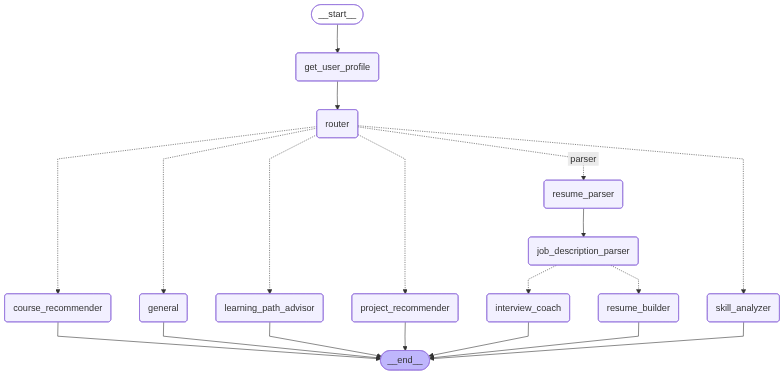

In [444]:
# Visualize the langgraph architecture
app

### CareerGraph AI — Conversational Memory Loop

This module runs the **interactive chat system** for CareerGraph AI, enabling live, memory-aware conversations with LangGraph agents.

---

#### Core Features

| Feature | Description |
|----------|-------------|
| **Exit Detection** | Uses a lightweight LLM prompt to check if user says “bye”, “exit”, etc. |
| **Memory Management** | Keeps last 10 user–AI exchanges in a rolling list |
| **Summarized Context** | Compresses prior conversation into 5-sentence summary for continuity |
| **Dynamic Agent Routing** | Sends each user query to the right agent via the LangGraph app |
| **Persistent Flow** | Continues the session until user explicitly ends it |

---

#### Flow Overview

1. **User Input → Exit Check**  
   - If user says “bye”, AI politely ends the session.

2. **Memory Update → Context Summary**  
   - Last 10 turns are summarized into a brief memory for context retention.

3. **State Construction → Agent Routing**  
   - Creates a `state` dict with:
     ```python
     {
       "input_text": <user message>,
       "memory_summary": <context summary>
     }
     ```
   - Sent to `app.invoke(state)` which routes through the LangGraph agent pipeline.

4. **AI Response → Memory Append**  
   - Response displayed and appended to rolling memory.

In [448]:
from langchain_core.prompts import ChatPromptTemplate

# Exit Detection Prompt
exit_prompt = ChatPromptTemplate.from_template(
    """
    You are a conversation manager.
    Given the user's latest message, decide if the user wants to end the conversation.
    
    If the user clearly says something like "bye", "thank you", "stop", "exit", "goodnight", etc., 
    respond ONLY with the single word: "exit".
    Otherwise, respond ONLY with the word: "continue"
    
    User message:
    {user_input}
    """
)

# Combine prompt with the language model
exit_chain = exit_prompt | llm

# Initialize Memory
memory = []          # Stores dialogue history
memory_summary = ""  # Compressed summary of recent context

# Main Conversation Loop
while True:
    # Get user input
    user_input = input("User: ")

    # Check if user wants to end the conversation
    should_continue = exit_chain.invoke({'user_input': user_input}).content.strip()

    if should_continue == "exit":
        print("AI: Goodbye 👋")
        break  # Exit loop gracefully

    # Retain only last 10 messages for context
    memory = memory[-10:]

    # If there’s existing conversation, summarize it
    if memory:
        summary_prompt = ChatPromptTemplate.from_template(
            "Summarize the key context of this conversation in 5 concise sentences:\n\n{conversation}"
        )
        formatted = "\n".join(memory)
        chain = summary_prompt | llm
        memory_summary = chain.invoke({"conversation": formatted}).content.strip()
    else:
        memory_summary = ""

    # Build the current conversation state
    state = {
        "input_text": user_input,
        "memory_summary": memory_summary,
    }

    # Invoke the main LangGraph app (routes to the right agent)
    result = app.invoke(state)
    response = result.get("response", "(No response)")

    # Display AI response
    print(f"AI: {response}\n")

    # Save latest messages in memory
    memory.append(f"User: {user_input}")
    memory.append(f"AI: {response}")

User:  what should i learn next?


AI: 🎯 Target Role: AI Engineer

🧩 Required Skills: Cloud Computing (AWS/GCP/Azure), Docker, Kubernetes, MLOps Principles and Tools (MLflow, DVC, Kubeflow), Prompt Engineering (Advanced), LLM Fine-tuning, Vector Databases (Pinecone, Weaviate, ChromaDB), API Design for Scalable AI Services, System Design for AI/ML Applications

🪜 Learning Roadmap:
- Master Containerization with Docker: Learn Docker fundamentals (Dockerfiles, images, containers, volumes, networks). Project: Containerize an existing AI project (e.g., BiasBusterAI or SmartAttend) into a Docker image and run it locally.
- Explore Cloud Platforms for AI Deployment: Choose one major cloud provider (e.g., AWS or GCP) and learn its AI/ML services (e.g., AWS SageMaker, GCP AI Platform). Focus on deploying a containerized ML model as an API endpoint. Project: Deploy a Dockerized ML model to a cloud platform, making it accessible via a REST API.
- Implement MLOps Practices: Understand MLOps lifecycle (data versioning, model version

User:  how is docker and kubernetes?


AI: Docker and Kubernetes are foundational technologies, especially crucial for your journey towards becoming a proficient AI Engineer, as we discussed previously. They are key components for building robust, scalable, and production-ready AI systems, particularly when deploying modern LLM applications in cloud environments.

Here's a breakdown of how they are:

Docker:
Docker is a platform that uses OS-level virtualization to deliver software in packages called containers. These containers are isolated, portable environments that bundle an application and all its dependencies (code, runtime, system tools, libraries, settings) into a single, consistent unit.

How it is for AI/ML Engineers:
  Dependency Management: AI/ML projects often have complex dependencies (specific Python versions, libraries like TensorFlow or PyTorch, CUDA versions for GPU access). Docker ensures that your model runs in the exact environment it was developed in, preventing "it works on my machine" issues.
  Repro

User:  great, thank you


AI: Goodbye 👋


In [7]:
%%writefile ../utils/get_profile.py
def get_user_profile_from():
    """
    Returns a structured dummy user profile for internal testing.

    Returns:
        dict: A dictionary containing user data with the following keys:
              - 'education'
              - 'certifications'
              - 'projects'
              - 'skills'
              - 'experience'
    """

    # Skills
    skills = [
        'Agentic AI', 'Retrieval Augmented Generation (RAG)', 'Large Language Models (LLMs)',
        'LangChain', 'Django', 'LSTM', 'Flask', 'Transformers', 'RNN', 'TensorFlow',
        'Supervised Learning', 'Unsupervised Learning', 'Pytorch', 'CNN', 'DBMS', 'DSA',
        'Statistics', 'SQL', 'AI', 'Linear Algebra', 'Calculus', 'PCA', 'Python',
        'Seaborn', 'Pandas', 'Numpy', 'Matplotlib', 'Scikit-learn', 'Data Analytics',
        'Data Science', 'Machine Learning', 'Jupyter Notebook', 'Git'
    ]

    # Certifications
    certifications = [
        {'name': 'Google Advanced Data Analytics', 'organization': 'Google'},
        {'name': 'IBM Data Science Professional Certificate', 'organization': 'IBM'},
        {'name': 'IBM RAG and Agentic AI: Build Next-Gen AI Systems', 'organization': 'IBM'},
        {'name': 'Deep Learning', 'organization': 'DeepLearningAI'},
        {'name': 'Machine Learning', 'organization': 'DeepLearningAI'},
        {'name': 'Mathematics for Machine Learning Specialization', 'organization': 'Imperial College London'},
        {'name': 'Mathematics for Machine Learning and Data Science', 'organization': 'DeepLearning.AI'},
        {'name': 'Python for Everybody Specialization', 'organization': 'University of Michigan'}
    ]

    # Projects
    projects = [
        {
            'name': 'BiasBusterAI: Text Bias Detection System',
            'start_date': 'October 2025',
            'end_date': 'October 2025',
            'description': (
                'Developed AI web app detecting biases (race, gender, profession, religion) '
                'with Bidirectional LSTM + Self Attention, achieving ~98% accuracy via TensorFlow. '
                'Created Flask interface with Plotly for real-time visualization of bias probabilities '
                'and attention weights. https://github.com/sheb1lmsp/BiasBusterAI'
            )
        },
        {
            'name': 'SmartAttend: An Automated Attendance Management System',
            'start_date': 'May 2025',
            'end_date': 'August 2025',
            'description': (
                'Developed a smart attendance management system using facial recognition to automate '
                'classroom attendance tracking. Leveraged PyTorch, MTCNN, and InceptionResNetV1 for '
                'face detection and recognition. Integrated with a Django web application featuring '
                'role-based dashboards. Streamlined attendance via group photo analysis. '
                'https://github.com/sheb1lmsp/smart_attend'
            )
        }
    ]

    # Education
    education = [
        {
            'degree': 'Bachelor of Computer Applications',
            'university': 'Bangalore University',
            'start_date': 'August 2022',
            'end_date': 'June 2025',
            'cgpa': '8.82'
        }
    ]

    # Experience (Empty Placeholder)
    experience = [
        {
            'title': '',
            'employment_type': '',
            'company': '',
            'start_date': '',
            'end_date': '',
            'location': '',
            'description': ''
        }
    ]

    # Return Unified Profile
    return {
        'education': education,
        'certifications': certifications,
        'projects': projects,
        'skills': skills,
        'experience': experience
    }

Overwriting ../utils/get_profile.py


In [8]:
%%writefile ../utils/llm.py
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI

def get_llm(model_name: str = "gemini-2.5-flash"):
    """
    Initialize and return a Google Generative AI (Gemini) model instance.

    Args:
        model_name (str, optional): Model name to use. Defaults to "gemini-2.5-flash".

    Returns:
        ChatGoogleGenerativeAI: Initialized LLM instance for use across the project.
    """
    # Load environment variables (expects GOOGLE_API_KEY in .env)
    load_dotenv()

    # Initialize the LLM with the specified model name
    llm = ChatGoogleGenerativeAI(model=model_name)

    return llm

Overwriting ../utils/llm.py


In [9]:
%%writefile ../state.py
# Import typing utilities for structured data representation
from typing import TypedDict, Literal, List, Dict, Optional, Any

# Define a schema for user projects
class Project(TypedDict):
    name: str
    start_date: str
    end_date: str
    description: str

# Define a schema for certifications
class Certification(TypedDict):
    name: str
    organization: str

# Define a schema for education details
class Education(TypedDict):
    degree: str
    university: str
    start_date: str
    end_date: str
    cgpa: float

# Define a schema for professional experience
class Experience(TypedDict):
    title: str
    employment_type: str
    company: str
    start_date: str
    end_date: str
    location: str
    description: str

# Define the central state structure used by agents
class State(TypedDict):
    # User input text or query
    input_text: str

    # Indicates which agent should handle the request
    agent_action: Optional[
        Literal[
            "course_recommender",
            "project_recommender",
            "interview_coach",
            "learning_path_advisor",
            "resume_builder",
            "skill_analyzer",
        ]
    ]

    # Structured user information
    skills: Optional[List[str]]
    certifications: Optional[List[Certification]]
    projects: Optional[List[Project]]
    education: Optional[List[Education]]
    experience: Optional[List[Experience]]

    # Memory summary for conversation continuity
    memory_summary: Optional[str]

    # Model-generated response text
    response: Optional[str]

    # Additional metadata or runtime information
    metadata: Optional[Dict]

    # File path to generated resume (if applicable)
    resume_path: Optional[str]

Overwriting ../state.py


In [44]:
%%writefile ../agents/router_agent.py
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from utils.llm import get_llm
from state import State

# Initialize LLM instance
llm = get_llm()

class AgentType(BaseModel):
    """Schema defining which agent should handle the user's query."""
    agent_name: str = Field(
        description="The name of the agent that should handle this query."
    )

def router(state: State) -> State:
    """
    Context-aware router for CareerGraph AI.
    Determines which specialized agent should handle the user's query
    using both the latest input and memory summary for context.
    """
    
    router_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the **RouterAgent** for CareerGraph AI — an intelligent, LLM-powered career assistant.

            Your goal:
            - Analyze the user's current query and overall context (from memory).
            - Determine which specialized agent should respond next.

            **Available agents:**
            1. "skill_analyzer" → For analyzing or improving the user’s skills.
            2. "project_recommender" → For project ideas, feedback, or inspiration.
            3. "course_recommender" → For course or certification suggestions.
            4. "learning_path_advisor" → For structured learning or career roadmaps.
            5. "resume_builder" → For creating or optimizing resumes.
            6. "interview_coach" → For interview guidance and preparation.
            7. "general" → For general assistance outside the above.

            **Output format:**
            Return ONLY one of the agent names listed above as a plain string (no punctuation, no explanations).
            Example:
            skill_analyzer
            """
        ),
        (
            "human",
            """
            User query: {input_text}

            Memory summary of prior context: {memory_summary}
            """
        )
    ])

    # Chain combines the structured prompt with the Gemini model output
    chain = router_prompt | llm.with_structured_output(AgentType)

    # Invoke router with both input and memory summary
    response = chain.invoke({
        "input_text": state["input_text"],
        "memory_summary": state.get("memory_summary", "")
    })

    # Return updated state with the chosen agent
    return {**state, "agent_action": response.agent_name}

Writing ../agents/router_agent.py


In [45]:
%%writefile ../agents/get_user_profile_agent.py
from state import State
from utils.get_profile import get_user_profile_from

def get_user_profile(state: State) -> State:
    """
    Agent Node: Loads the user profile from the database and updates the shared state.

    This function fetches stored user data (skills, education, experience, etc.)
    and injects it into the active CareerGraph AI state for downstream agents to use.

    Args:
        state (State): The current CareerGraph AI state object.

    Returns:
        State: Updated state containing the user profile data.
    """

    # Fetch user profile data from a database or API (to be implemented)
    profile_data: Dict[str, Any] = get_user_profile_from()

    # Update the shared state with profile details
    state["skills"] = profile_data.get("skills", [])
    state["education"] = profile_data.get("education", [])
    state["experience"] = profile_data.get("experience", [])
    state["projects"] = profile_data.get("projects", [])
    state["certifications"] = profile_data.get("certifications", [])

    # Return updated state for downstream use
    return state

Writing ../agents/get_user_profile_agent.py


In [46]:
%%writefile ../agents/course_recommender_agent.py
from langchain_core.prompts import ChatPromptTemplate
from utils.llm import get_llm
from state import State

# Initialize LLM instance
llm = get_llm()

def course_recommender(state: State) -> State:
    """
    Agent Node: Suggests relevant courses or certifications based on the user's profile.

    This agent analyzes the user's current skills, education, projects, and certifications
    to recommend 3–5 relevant courses or certifications from top learning platforms.
    It avoids recommending duplicates or already-completed certifications.

    Args:
        state (State): The current shared CareerGraph AI state.

    Returns:
        State: Updated state with 'response' containing the course recommendations.
    """

    # Extract key user info from the shared state
    user_skills = state.get("skills", [])
    education = state.get("education", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])
    user_query = state.get("input_text", "")
    memory_summary = state.get("memory_summary", "")

    # Define the prompt with memory and structured context
    course_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the CourseRecommender Agent for CareerGraph AI.

            Your goal is to suggest highly relevant online courses or certifications
            from platforms like Coursera, Udemy, edX, Google, or LinkedIn Learning
            that help the user progress in their desired career path.

            ⚠️ Rules:
            - Do NOT recommend any course or certification the user already has or mentioned.
            - Do NOT repeat known certifications.
            - Focus on next-step or complementary learning.
            - Recommend 3–5 courses only.
            - For each course: include platform and one-line relevance.
            - Output must be plain text (no JSON, no markdown).
            """
        ),
        (
            "human",
            """
            User query or goal:
            {user_query}

            Memory summary (context from previous discussion):
            {memory_summary}

            User profile:
            - Skills: {user_skills}
            - Education: {education}
            - Projects: {projects}
            - Completed Certifications: {certifications}

            Return 3–5 unique, relevant courses in this format:

            1. [Course Name] — [Platform]
               Why: [One-line reason]
            2. [Course Name] — [Platform]
               Why: [One-line reason]
            """
        ),
    ])

    # Build the chain and get model output
    chain = course_prompt | llm
    response = chain.invoke({
        "user_query": user_query,
        "memory_summary": memory_summary,
        "user_skills": user_skills,
        "education": education,
        "projects": projects,
        "certifications": certifications,
    })

    # Store the AI's course recommendations in the shared state
    state["response"] = response.content.strip()

    # Return updated state
    return state

Writing ../agents/course_recommender_agent.py


In [47]:
%%writefile ../agents/project_recommender_agent.py
from langchain_core.prompts import ChatPromptTemplate
from utils.llm import get_llm
from state import State

# Initialize LLM instance
llm = get_llm()

def project_recommender(state: State) -> State:
    """
    Agent Node: Suggests creative and technically relevant project ideas for the user.

    This agent analyzes the user's profile — skills, education, experience, and goals —
    to recommend unique, high-impact project ideas that improve employability and portfolio depth.
    It ensures that suggestions avoid overlap with existing projects and remain challenging yet achievable.

    Args:
        state (State): The current shared CareerGraph AI state.

    Returns:
        State: Updated state containing project recommendations in 'response'.
    """

    # Extract user info and context from the shared state
    user_skills = ", ".join(state.get("skills", []))
    education = state.get("education", [])
    experience = state.get("experience", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])
    user_query = state.get("input_text", "")
    memory_summary = state.get("memory_summary", "")

    # Define the project recommendation prompt
    project_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the ProjectRecommender Agent for CareerGraph AI.

            Your task:
            - Suggest unique, high-impact project ideas tailored to the user’s skills, experience, and goals.
            - Help the user build portfolio depth and improve employability.

            ⚙️ Rules:
            - Do NOT suggest projects too similar to existing ones.
            - Suggest 3–5 creative, technically strong project ideas.
            - Include a one-line reason why each project is valuable.
            - Prefer ideas slightly above current skill level to encourage growth.
            - Avoid trivial projects (e.g., "To-Do App", "Calculator App").
            - Output plain text only — no markdown, no JSON.

            🎯 Example directions:
            - For AI/ML skills → applied ML, NLP, GenAI, automation.
            - For software/dev → scalable systems, developer tools.
            - For data analytics → dashboards, predictive models, business insights.
            """
        ),
        (
            "human",
            """
            User query or goal:
            {user_query}

            Memory summary (context from prior interactions):
            {memory_summary}

            User profile:
            - Skills: {user_skills}
            - Education: {education}
            - Experience: {experience}
            - Certifications: {certifications}
            - Existing Projects: {projects}

            Recommend 3–5 unique, creative projects the user can build next.
            Each should include:
            1. Project Name — short and creative
            2. Description — one sentence
            3. Why — brief reason of value

            Format strictly:
            1. [Project Name]
               Description: ...
               Why: ...
            """
        ),
    ])

    # Build the chain and invoke with all context
    chain = project_prompt | llm
    response = chain.invoke({
        "user_query": user_query,
        "memory_summary": memory_summary,
        "user_skills": user_skills,
        "education": education,
        "experience": experience,
        "projects": projects,
        "certifications": certifications,
    })

    # Store generated projects in the state
    state["response"] = response.content.strip()

    # Return the updated state
    return state

Writing ../agents/project_recommender_agent.py


In [48]:
%%writefile ../agents/learning_path_advisor_agent.py
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from utils.llm import get_llm
from state import State
from typing import List

# Initialize LLM instance
llm = get_llm()

class LearningPath(BaseModel):
    """Structured schema representing a user's personalized learning roadmap."""
    target_role: str = Field(description="The career goal or target role the user aims to achieve.")
    required_skills: List[str] = Field(description="New or complementary skills the user needs to learn.")
    roadmap_steps: List[str] = Field(description="Ordered learning steps or milestones.")
    recommended_resources: List[str] = Field(description="Suggested learning materials or platforms.")
    summary: str = Field(description="A concise overview of the personalized learning roadmap.")


def learning_path_advisor(state: State) -> State:
    """
    Agent Node: Generates a step-by-step learning roadmap toward the user's target role.

    This agent analyzes the user's background, known skills, and career goals to design
    a progressive, goal-oriented learning plan. It avoids recommending already-known topics
    and emphasizes real-world applicability and measurable growth.
    """
    # Extract key profile elements from the shared state
    user_input = state.get("input_text", "")
    known_skills = ", ".join(state.get("skills", []))
    certifications = state.get("certifications", [])
    education = state.get("education", [])
    experience = state.get("experience", [])
    projects = state.get("projects", [])
    memory_summary = state.get("memory_summary", "") 

    # Build the structured LLM prompt
    learning_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the LearningPath Advisor for CareerGraph AI.
            Your role is to create personalized, practical, and efficient learning roadmaps
            tailored to each user’s profile, skills, and career ambitions.

            ✅ Guidelines:
            - Recommend only NEW or relevant skills (avoid known ones).
            - Exclude any courses, certifications, or topics the user already completed.
            - Keep steps chronological, measurable, and realistic.
            - Include real-world projects, milestones, and portfolio tasks.
            - Use the conversation memory to maintain context continuity.
            - If no goal is provided, infer a likely target role.
            """
        ),
        (
            "human",
            """
            User Query: {user_input}

            Memory Summary: {memory_summary}

            Profile Summary:
            - Known Skills: {known_skills}
            - Certifications: {certifications}
            - Education: {education}
            - Experience: {experience}
            - Projects: {projects}

            Provide a structured learning roadmap with:
            - target_role
            - required_skills (excluding known ones)
            - roadmap_steps (in logical order)
            - recommended_resources
            - summary
            """
        ),
    ])

    # Chain the prompt with structured output schema
    chain = learning_prompt | llm.with_structured_output(LearningPath)

    # Invoke the LLM with user context and memory
    response = chain.invoke({
        "user_input": user_input,
        "known_skills": known_skills,
        "certifications": certifications,
        "education": education,
        "experience": experience,
        "projects": projects,
        "memory_summary": memory_summary,
    })

    # Format output into a user-friendly text block
    formatted_output = (
        f"🎯 Target Role: {response.target_role}\n\n"
        f"🧩 Required Skills: {', '.join(response.required_skills)}\n\n"
        f"🪜 Learning Roadmap:\n" + "\n".join([f"- {step}" for step in response.roadmap_steps]) + "\n\n"
        f"📘 Recommended Resources:\n" + "\n".join([f"- {r}" for r in response.recommended_resources]) + "\n\n"
        f"📝 Summary: {response.summary}"
    )

    # Store result back in shared state
    state["response"] = formatted_output
    return state

Writing ../agents/learning_path_advisor_agent.py


In [49]:
%%writefile ../agents/skill_analyzer_agent.py
from langchain_core.prompts import ChatPromptTemplate
from utils.llm import get_llm
from state import State

# Initialize LLM instance
llm = get_llm()

def skill_analyzer(state: State) -> State:
    """
    Agent Node: Analyzes the user's skills, experience, and projects to identify
    their core strengths, weaknesses, and upskilling opportunities.
    """
    # Extract all relevant information from the state
    input_text = state.get("input_text", "")
    skills = state.get("skills", [])
    education = state.get("education", [])
    experience = state.get("experience", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])
    memory_summary = state.get("memory_summary", "") 

    # Build the structured prompt for the LLM
    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the Skill Analyzer Agent for CareerGraph AI.

            Your task:
            - Analyze the user's skills, experience, and projects.
            - Identify their strongest and most relevant skills.
            - Highlight weak or missing skill areas.
            - Recommend next-step upskilling opportunities (tools, frameworks, or soft skills).
            - Use conversation memory to ensure continuity and avoid repeating suggestions.

            Output format (plain text only):
            Core Strengths:
            - ...

            Missing / Weak Skills:
            - ...

            Recommended Upskilling:
            - ...

            Suggested Courses / Certifications:
            - ...
            """
        ),
        (
            "human",
            """
            User Query: {input_text}

            Memory Summary: {memory_summary}

            Profile Data:
            - Skills: {skills}
            - Education: {education}
            - Experience: {experience}
            - Projects: {projects}
            - Certifications: {certifications}
            """
        ),
    ])

    # Chain the prompt with the LLM and generate analysis
    chain = prompt | llm
    response = chain.invoke({
        "input_text": input_text,
        "memory_summary": memory_summary,
        "skills": skills,
        "education": education,
        "experience": experience,
        "projects": projects,
        "certifications": certifications,
    })

    # Store the generated analysis in the state
    state["response"] = response.content.strip()
    return state

Writing ../agents/skill_analyzer_agent.py


In [50]:
%%writefile ../agents/general_agent.py
from langchain_core.prompts import ChatPromptTemplate
from utils.llm import get_llm
from state import State

# Initialize LLM instance
llm = get_llm()

def general(state: State) -> State:
    """
    Agent Node: Responds to general or uncategorized user queries that don't match
    specific agents like skill_analyzer, course_recommender, etc.
    If the query is not career-related, it explicitly refuses to answer.
    """
    # Extract relevant information from the shared state
    input_text = state.get("input_text", "")
    skills = state.get("skills", [])
    education = state.get("education", [])
    experience = state.get("experience", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])
    memory_summary = state.get("memory_summary", "")

    # Build a general-purpose prompt for free-form conversation
    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the General Agent for CareerGraph AI.

            Your task:
            - Handle general, open-ended, or advisory career-related queries.
            - Use the user's background and memory summary for context.
            - If the query is NOT career-related (e.g., about entertainment, math, jokes, or random facts),
              clearly respond with: "Sorry, I can only help with career-related topics."
            - If it IS career-related, provide relevant, professional, and actionable advice.
            - Always output plain text (no markdown, no JSON).
            """
        ),
        (
            "human",
            """
            User Query: {input_text}

            Memory Summary: {memory_summary}

            Profile Data:
            - Skills: {skills}
            - Education: {education}
            - Experience: {experience}
            - Projects: {projects}
            - Certifications: {certifications}
            """
        ),
    ])

    # Chain the prompt with the LLM
    chain = prompt | llm

    # Invoke the model with user and memory context
    response = chain.invoke({
        "input_text": input_text,
        "memory_summary": memory_summary,
        "skills": skills,
        "education": education,
        "experience": experience,
        "projects": projects,
        "certifications": certifications,
    })

    # Save and return the response
    state["response"] = response.content.strip()
    return state

Writing ../agents/general_agent.py


In [51]:
%%writefile ../agents/job_description_parser_agent.py
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import List
from utils.llm import get_llm
from state import State

# Initialize LLM instance
llm = get_llm()

class JobDescriptionModel(BaseModel):
    """Structured schema representing extracted details from a job description."""
    is_job_description: bool = Field(description="True if the input contains a job description or job post.")
    job_title: str = Field(default="", description="The job title or role name, if mentioned.")
    company: str = Field(default="", description="The company name, if mentioned.")
    required_skills: List[str] = Field(default_factory=list, description="List of technical or soft skills mentioned.")
    responsibilities: List[str] = Field(default_factory=list, description="List of key responsibilities or tasks mentioned.")
    experience_level: str = Field(default="", description="Experience level (e.g., Entry-level, Mid-level, Senior), if detectable.")
    summary: str = Field(default="", description="2-line summary of what the role is about.")


def job_description_parser(state: State) -> State:
    """
    Agent Node: Parses structured job description data from the user's input.
    
    This agent:
    - Detects whether the text is a job description.
    - Extracts relevant structured information.
    - Stores it under `state['metadata']['job_description']`.
    - Does NOT produce direct output; it's used for internal data enrichment.
    """
    user_query = state.get("input_text", "")

    jd_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the JobDescriptionParser Agent for CareerGraph AI.

            Your task:
            - Detect if the user input contains a job description or job post.
            - If yes, extract:
              • job_title
              • company
              • required_skills
              • responsibilities
              • experience_level
              • summary
            - If not, set is_job_description=False.
            - Be concise, structured, and factual.
            - Return only structured output, no commentary or natural language text.
            """
        ),
        (
            "human",
            "User Input:\n{user_query}"
        )
    ])

    # Structured LLM call
    chain = jd_prompt | llm.with_structured_output(JobDescriptionModel)
    response = chain.invoke({"user_query": user_query})

    # Initialize metadata container if missing
    if state.get("metadata") is None:
        state["metadata"] = {}

    # Store extracted job description details
    state["metadata"]["job_description"] = response.model_dump()

    return state

Writing ../agents/job_description_parser_agent.py


In [52]:
%%writefile ../utils/extract_resume.py
import fitz  # PyMuPDF — for reading PDF files
from docx import Document  # for reading .docx files

def extract_resume_text(file_path: str) -> str:
    """
    Extract clean text from resume files (.pdf or .docx).
    
    Automatically detects the file type and extracts textual content accordingly.
    
    Args:
        file_path (str): Path to the resume file.

    Returns:
        str: Extracted plain text content.
    """
    
    # Handle PDF resume extraction
    if file_path.endswith(".pdf"):
        text = ""
        with fitz.open(file_path) as pdf:
            for page in pdf:
                text += page.get_text("text") + "\n"
        return text.strip()
    
    # Handle DOCX resume extraction
    elif file_path.endswith(".docx"):
        doc = Document(file_path)
        text = "\n".join([p.text for p in doc.paragraphs])
        return text.strip()
    
    # Unsupported file format
    else:
        raise ValueError("Unsupported file type. Please upload a PDF or DOCX resume.")

Overwriting ../utils/extract_resume.py


In [53]:
%%writefile ../agents/resume_parser_agent.py
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import List
from utils.llm import get_llm
from state import State
from utils.extract_resume import extract_resume_text

# Initialize LLM instance
llm = get_llm()

class ResumeModel(BaseModel):
    """Structured schema representing parsed resume information."""
    is_resume: bool = Field(description="True if the input contains a resume.")
    name: str = Field(default="", description="Full name of the candidate, if available.")
    email: str = Field(default="", description="Email address of the candidate, if mentioned.")
    phone: str = Field(default="", description="Phone number, if available.")
    summary: str = Field(default="", description="Brief 2–3 line professional summary.")
    skills: List[str] = Field(default_factory=list, description="List of technical or soft skills.")
    education: List[str] = Field(default_factory=list, description="List of educational qualifications and institutions.")
    experience: List[str] = Field(default_factory=list, description="List of work experience entries or job roles.")
    certifications: List[str] = Field(default_factory=list, description="List of certifications or achievements.")
    projects: List[str] = Field(default_factory=list, description="List of project titles or brief descriptions.")
    total_experience_years: float = Field(default=0.0, description="Approximate total years of experience.")


def resume_parser(state: State) -> State:
    """
    Resume Parser Agent — extracts structured data from resumes.

    This agent uses LLM parsing to convert unstructured resume text into a 
    structured dictionary that downstream agents (like Interview Coach or 
    Resume Builder) can consume.

    Behavior:
    - Reads text from the provided resume file (PDF or DOCX).
    - Parses fields like name, email, skills, experience, etc.
    - Stores results inside `state['metadata']['resume_data']`.
    - Does NOT overwrite main state-level user info.
    """

    # Get the file path to the user's uploaded resume
    resume_path = state.get("resume_path", None)

    # Extract text using the unified loader
    if resume_path is not None:
        resume_text = extract_resume_text(resume_path)
    else:
        resume_text = "None"

    # Build the LLM prompt
    resume_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the ResumeParser Agent for CareerGraph AI.

            Your task:
            - Analyze the provided resume text.
            - Extract the following structured fields:
              • name
              • email
              • phone
              • summary
              • skills
              • education
              • experience
              • certifications
              • projects
              • total_experience_years (approx)
            - If no resume data is found, make the 'is_resume' field False and leave other fields empty.
            - Return output strictly following the structured schema (ResumeModel).
            """
        ),
        ("human", "Resume text:\n{resume_text}")
    ])

    # Chain the prompt to the LLM with structured output
    chain = resume_prompt | llm.with_structured_output(ResumeModel)
    response = chain.invoke({"resume_text": resume_text})

    # Store parsed data in the metadata section of the state
    if state.get("metadata") is None:
        state["metadata"] = {}

    state["metadata"]["resume_data"] = response.model_dump()

    return state

Writing ../agents/resume_parser_agent.py


In [54]:
%%writefile ../agents/interview_coach_agent.py
from langchain_core.prompts import ChatPromptTemplate
from utils.llm import get_llm
from state import State

# Initialize LLM instance
llm = get_llm()

def interview_coach(state: State) -> State:
    """
    CareerGraph AI — Interview Coach Agent

    Dynamically generates interview guidance depending on available data:
    - If both Job Description & Resume are available → use both for a tailored prep plan  
    - If only Job Description is available → focus on that role and requirements  
    - If only Resume is available → focus on the candidate's background  
    - If none are available → use user's profile information from the state  

    Also leverages conversation memory (`memory_summary`) for personalized continuity.

    Output includes:
    1. Role Context
    2. Key Focus Areas
    3. Likely Technical & Behavioral Questions
    4. Preparation Tips
    5. Bonus Recommendations (optional)
    """

    # Extract available metadata
    metadata = state.get("metadata", {})
    job_description = metadata.get("job_description", {})
    resume_data = metadata.get("resume_data", {})

    # Fallback user profile data
    skills = state.get("skills", [])
    experience = state.get("experience", [])
    education = state.get("education", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])
    memory_summary = state.get("memory_summary", "")
    input_text = state.get("input_text", "")

    # Build the context dynamically based on available data
    context_parts = []

    # If Job Description exists
    if job_description and job_description.get("is_job_description", False):
        context_parts.append(
            "Job Description Details:\n"
            f"- Role: {job_description.get('job_title', 'N/A')}\n"
            f"- Company: {job_description.get('company', 'N/A')}\n"
            f"- Required Skills: {', '.join(job_description.get('required_skills', []))}\n"
            f"- Responsibilities: {', '.join(job_description.get('responsibilities', []))}\n"
            f"- Experience Level: {job_description.get('experience_level', 'N/A')}\n"
            f"- Summary: {job_description.get('summary', 'N/A')}\n"
        )

    # If Resume data exists
    if resume_data and resume_data.get("is_resume", False):
        context_parts.append(
            "Resume Details:\n"
            f"- Name: {resume_data.get('name', 'N/A')}\n"
            f"- Skills: {', '.join(resume_data.get('skills', []))}\n"
            f"- Experience: {', '.join(resume_data.get('experience', []))}\n"
            f"- Projects: {', '.join(resume_data.get('projects', []))}\n"
            f"- Education: {', '.join(resume_data.get('education', []))}\n"
        )

    # Fallback — if neither JD nor Resume is present
    if not context_parts:
        context_parts.append(
            "User Profile Summary:\n"
            f"- Skills: {', '.join(skills)}\n"
            f"- Experience: {', '.join([exp.get('title', 'N/A') + ' at ' + exp.get('company', 'N/A') for exp in experience])}\n"
            f"- Education: {', '.join([edu.get('degree', 'N/A') + ' at ' + edu.get('university', 'N/A') for edu in education])}\n"
            f"- Projects: {', '.join([p.get('name', 'N/A') for p in projects])}\n"
            f"- Certifications: {', '.join([c.get('name', 'N/A') for c in certifications])}\n"
        )

    # Combine all context parts
    combined_context = "\n\n".join(context_parts)

    # Define the LLM prompt
    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
            You are the **Interview Coach Agent** for CareerGraph AI.

            Your mission:
            - Prepare the user for their upcoming job interview.
            - Use Job Description and/or Resume data if provided.
            - If only user profile info is available, base preparation on that.
            - If `memory_summary` is provided, use it to recall the user's previous interactions.

            Output structure:
            1. Role Context (1–2 lines)
            2. Key Focus Areas
            3. Likely Technical Questions
            4. Behavioral Questions
            5. Preparation Tips
            6. Bonus Recommendations (optional)

            Keep tone professional, supportive, and realistic.
            Output plain text only (no markdown or JSON).
            """
        ),
        (
            "human",
            """
            Memory Summary:
            {memory_summary}

            User Query:
            {input_text}

            Combined Context:
            {combined_context}
            """
        )
    ])

    # Execute the chain with context + memory
    chain = prompt | llm
    response = chain.invoke({
        "input_text": input_text,
        "combined_context": combined_context,
        "memory_summary": memory_summary,
    })

    # Save the LLM response to shared state
    state["response"] = response.content.strip()

    return state

Writing ../agents/interview_coach_agent.py


In [55]:
%%writefile ../agents/resume_builder_agent.py
from langchain_core.prompts import ChatPromptTemplate
from utils.llm import get_llm
from state import State

# Initialize LLM instance
llm = get_llm()

def resume_builder(state: State) -> State:
    """
    CareerGraph AI — Resume Builder Agent (ATS + HR Selection Model)

    Dynamically generates optimized resumes depending on available data:
    - Both Job Description & Resume → Tailor resume precisely to role.
    - Only Job Description → Create resume using profile data, tailored to JD.
    - Only Resume → Improve and optimize that resume.
    - Neither → Build complete resume only from user's profile (skills, experience, etc.).

    Phase 1 — ATS Engine:
        • Produces 5 ATS-optimized variations (technical, managerial, concise, etc.)
    Phase 2 — HR Reviewer:
        • Picks the most impactful version and outputs only that resume.
    """

    # Extract metadata safely
    metadata = state.get("metadata", {})
    job_description = metadata.get("job_description", {})
    resume_data = metadata.get("resume_data", {})

    # Extract general state info
    input_text = state.get("input_text", "")
    memory_summary = state.get("memory_summary", "")
    skills = state.get("skills", [])
    experience = state.get("experience", [])
    education = state.get("education", [])
    projects = state.get("projects", [])
    certifications = state.get("certifications", [])

    context_parts = []
    tailoring_instruction = ""

    # === Case 1: Both JD + Resume present ===
    if job_description.get("is_job_description") and resume_data.get("is_resume"):
        tailoring_instruction = (
            "Both a job description and a resume are provided. "
            "Tailor the resume exactly for this role, aligning achievements and skills "
            "to the job’s required qualifications. Keep ATS optimization and clarity."
        )
        context_parts.append("=== Job Description ===\n")
        context_parts.append(
            f"Role: {job_description.get('job_title', 'N/A')}\n"
            f"Company: {job_description.get('company', 'N/A')}\n"
            f"Required Skills: {', '.join(job_description.get('required_skills', []))}\n"
            f"Responsibilities: {', '.join(job_description.get('responsibilities', []))}\n"
            f"Experience Level: {job_description.get('experience_level', 'N/A')}\n"
            f"Summary: {job_description.get('summary', '')}\n"
        )
        context_parts.append("\n=== Existing Resume ===\n")
        context_parts.append(str(resume_data))

    # === Case 2: Only JD present ===
    elif job_description.get("is_job_description"):
        tailoring_instruction = (
            "Only a job description is available. Use the user’s stored profile "
            "to build a tailored resume aligned to this job’s role and requirements."
        )
        context_parts.append("=== Job Description ===\n")
        context_parts.append(
            f"Role: {job_description.get('job_title', 'N/A')}\n"
            f"Company: {job_description.get('company', 'N/A')}\n"
            f"Required Skills: {', '.join(job_description.get('required_skills', []))}\n"
            f"Responsibilities: {', '.join(job_description.get('responsibilities', []))}\n"
            f"Experience Level: {job_description.get('experience_level', 'N/A')}\n"
        )
        context_parts.append("\n=== User Profile ===\n")
        context_parts.append(
            f"Skills: {', '.join(skills)}\n"
            f"Experience: {', '.join([exp.get('title', 'N/A') + ' at ' + exp.get('company', 'N/A') for exp in experience])}\n"
            f"Education: {', '.join([edu.get('degree', 'N/A') + ' at ' + edu.get('university', 'N/A') for edu in education])}\n"
            f"Projects: {', '.join([p.get('name', 'N/A') for p in projects])}\n"
            f"Certifications: {', '.join([c.get('name', 'N/A') for c in certifications])}\n"
        )

    # === Case 3: Only Resume present ===
    elif resume_data.get("is_resume"):
        tailoring_instruction = (
            "Only a resume is provided. Improve and optimize it for ATS compliance and clarity. "
            "Use user profile data to fill missing gaps or enhance detail."
        )
        context_parts.append("=== Existing Resume ===\n")
        context_parts.append(str(resume_data))
        context_parts.append("\n=== User Profile Supplement ===\n")
        context_parts.append(
            f"Skills: {', '.join(skills)}\n"
            f"Experience: {', '.join([exp.get('title', 'N/A') + ' at ' + exp.get('company', 'N/A') for exp in experience])}\n"
        )

    # === Case 4: No JD or Resume ===
    else:
        tailoring_instruction = (
            "No job description or resume provided. Build a professional, "
            "ATS-optimized resume based solely on user profile data."
        )
        context_parts.append("=== User Profile ===\n")
        context_parts.append(
            f"Skills: {', '.join(skills)}\n"
            f"Experience: {', '.join([exp.get('title', 'N/A') + ' at ' + exp.get('company', 'N/A') for exp in experience])}\n"
            f"Education: {', '.join([edu.get('degree', 'N/A') + ' at ' + edu.get('university', 'N/A') for edu in education])}\n"
            f"Projects: {', '.join([p.get('name', 'N/A') for p in projects])}\n"
            f"Certifications: {', '.join([c.get('name', 'N/A') for c in certifications])}\n"
        )

    combined_context = "\n".join(context_parts)

    # Prompt definition
    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            f"""
            You are the Resume Builder Agent for CareerGraph AI.

            {tailoring_instruction}

            Use the information and memory context below to generate your output.

            === PROCESS ===
            Phase 1 — ATS Engine:
              • Generate FIVE unique, ATS-optimized resume drafts (technical, managerial, concise, academic, creative).
              • Each follows this structure:
                ======================
                [FULL NAME]
                [PROFESSIONAL SUMMARY]
                [SKILLS]
                [EXPERIENCE]
                [PROJECTS]
                [EDUCATION]
                [CERTIFICATIONS]
                ======================

            Phase 2 — HR Reviewer:
              • Choose the ONE resume version most likely to pass both ATS and human review.
              • Output ONLY that chosen resume.
              • Do NOT include the other drafts or your reasoning.
              • Keep formatting consistent and professional.
            """
        ),
        (
            "human",
            """
            Memory Summary:
            {memory_summary}

            User Query:
            {input_text}

            Context Information:
            {combined_context}
            """
        )
    ])

    # LLM Execution
    chain = prompt | llm
    response = chain.invoke({
        "input_text": input_text,
        "combined_context": combined_context,
        "memory_summary": memory_summary,
    })

    # Save to state
    state["response"] = response.content.strip()
    return state

Writing ../agents/resume_builder_agent.py


In [56]:
%%writefile ../graph_builder.py
from langgraph.graph import StateGraph, START, END

# Import all agents and nodes
from agents.router_agent import router
from agents.general_agent import general
from agents.course_recommender_agent import course_recommender
from agents.project_recommender_agent import project_recommender
from agents.interview_coach_agent import interview_coach
from agents.learning_path_advisor_agent import learning_path_advisor
from agents.resume_builder_agent import resume_builder
from agents.skill_analyzer_agent import skill_analyzer
from agents.resume_parser_agent import resume_parser
from agents.job_description_parser_agent import job_description_parser
from agents.get_user_profile_agent import get_user_profile
from state import State 


def build_graph() -> StateGraph:
    """
    Build and compile the full CareerGraph AI workflow using LangGraph.

    This function:
    - Initializes the state graph with the shared `State` class.
    - Adds all agent nodes to the graph.
    - Defines routing and conditional edges for dynamic flow control.
    - Compiles and returns the final executable graph.

    Returns:
        Graph: A compiled LangGraph app instance ready for use.
    """

    # Initialize the graph with the shared state type
    graph = StateGraph(State)

    # Add All Agent Nodes
    graph.add_node("get_user_profile", get_user_profile)       # Fetch or initialize user data
    graph.add_node("router", router)                           # Routes user queries to agents
    graph.add_node("general", general)                         # Handles general/fallback queries
    graph.add_node("course_recommender", course_recommender)   # Suggests learning courses
    graph.add_node("project_recommender", project_recommender) # Recommends projects
    graph.add_node("interview_coach", interview_coach)         # Prepares user for interviews
    graph.add_node("learning_path_advisor", learning_path_advisor) # Suggests learning paths
    graph.add_node("resume_builder", resume_builder)           # Builds or optimizes resumes
    graph.add_node("skill_analyzer", skill_analyzer)           # Analyzes user skills
    graph.add_node("resume_parser", resume_parser)             # Parses resume content
    graph.add_node("job_description_parser", job_description_parser) # Parses job descriptions

    # Define Graph Edges and Logic
    
    # Entry flow: start from profile setup → router
    graph.add_edge(START, "get_user_profile")
    graph.add_edge("get_user_profile", "router")

    # Conditional routing from router to the appropriate agent
    graph.add_conditional_edges(
        "router",
        lambda state: (
            state["agent_action"]
            if state["agent_action"] not in ["interview_coach", "resume_builder"]
            else "parser"
        ),
        {
            "course_recommender": "course_recommender",
            "project_recommender": "project_recommender",
            "parser": "resume_parser",
            "learning_path_advisor": "learning_path_advisor",
            "skill_analyzer": "skill_analyzer",
            "general": "general",
        },
    )

    # Parser flow: resume → job description → specific agent
    graph.add_edge("resume_parser", "job_description_parser")
    graph.add_conditional_edges(
        "job_description_parser",
        lambda state: state["agent_action"],
        {
            "resume_builder": "resume_builder",
            "interview_coach": "interview_coach",
        },
    )

    # Define Endpoints
    for end_node in [
        "course_recommender",
        "project_recommender",
        "interview_coach",
        "learning_path_advisor",
        "resume_builder",
        "skill_analyzer",
        "general",
    ]:
        graph.add_edge(end_node, END)

    # Compile Final Graph App
    app = graph.compile()

    return app

Overwriting ../graph_builder.py


In [57]:
%%writefile ../conversation_manager.py
from langchain_core.prompts import ChatPromptTemplate
from utils.llm import get_llm
from graph_builder import build_graph

# Initialize LLM instance
llm = get_llm()

# Initialize LangGraph Multi-Agent
app = build_graph()

# Exit Detection Prompt
exit_prompt = ChatPromptTemplate.from_template(
    """
    You are a conversation manager.
    Given the user's latest message, decide if the user wants to end the conversation.
    
    If the user clearly says something like "bye", "thank you", "stop", "exit", "goodnight", etc., 
    respond ONLY with the single word: "exit".
    Otherwise, respond ONLY with the word: "continue"
    
    User message:
    {user_input}
    """
)

# Combine prompt with the language model
exit_chain = exit_prompt | llm

# Initialize Memory
memory = []          # Stores dialogue history
memory_summary = ""  # Compressed summary of recent context

# Main Conversation Loop
while True:
    # Get user input
    user_input = input("User: ")

    # Check if user wants to end the conversation
    should_continue = exit_chain.invoke({'user_input': user_input}).content.strip()

    if should_continue == "exit":
        print("AI: Goodbye 👋")
        break  # Exit loop gracefully

    # Retain only last 10 messages for context
    memory = memory[-10:]

    # If there’s existing conversation, summarize it
    if memory:
        summary_prompt = ChatPromptTemplate.from_template(
            "Summarize the key context of this conversation in 5 concise sentences:\n\n{conversation}"
        )
        formatted = "\n".join(memory)
        chain = summary_prompt | llm
        memory_summary = chain.invoke({"conversation": formatted}).content.strip()
    else:
        memory_summary = ""

    # Build the current conversation state
    state = {
        "input_text": user_input,
        "memory_summary": memory_summary,
    }

    # Invoke the main LangGraph app (routes to the right agent)
    result = app.invoke(state)
    response = result.get("response", "(No response)")

    # Display AI response
    print(f"AI: {response}\n")

    # Save latest messages in memory
    memory.append(f"User: {user_input}")
    memory.append(f"AI: {response}")

Overwriting ../conversation_manager.py
